# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 29

## Student 1 
### Name : Mingyu Gao
### ID : 5216281

## Student 2
### Name : Yuhang Tian
### ID : 5219728

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [2]:
# load the data
training_data = pd.read_csv('./SWaT_train.csv')
testing_data = pd.read_csv('./SWaT_test.csv')

training_signals = training_data.drop(columns=[' Timestamp', 'Normal/Attack'])
training_label = training_data['Normal/Attack']
training_label = np.where(training_label.to_numpy() == 'Normal', 0, 1)

testing_signals = testing_data.drop(columns=['Unnamed: 0', ' Timestamp', 'Normal/Attack'])
testing_label = testing_data['Normal/Attack']
testing_label = np.where(testing_label.to_numpy() == 'Normal', 0, 1)

training_data.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


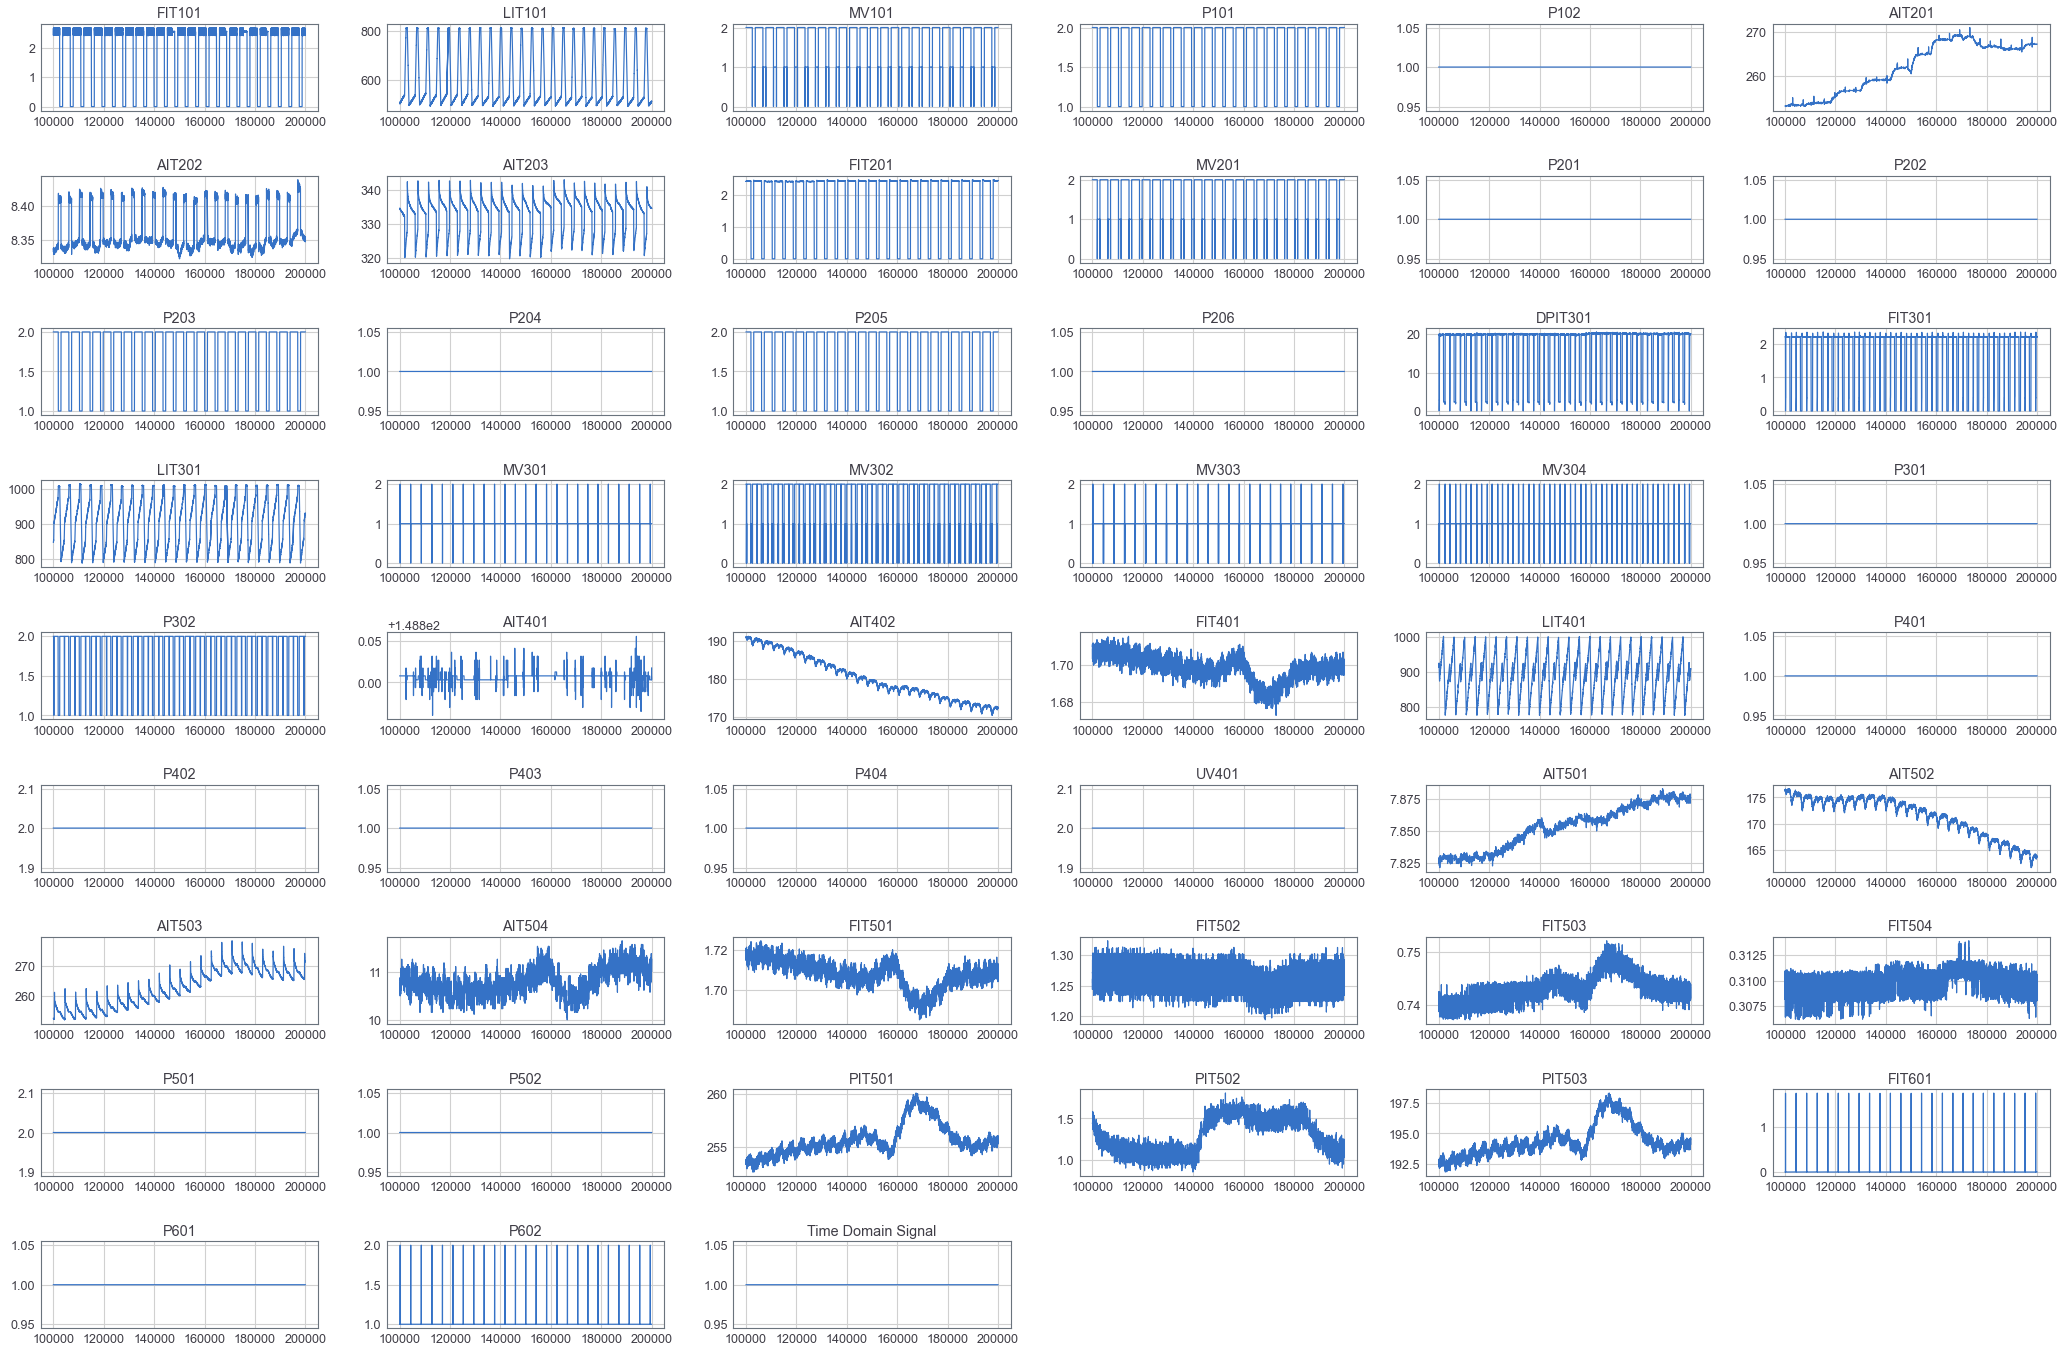

In [3]:
# to visualize patrial data
i = 1
plt.figure(figsize=(36, 24))
plt.subplots_adjust(wspace=0.25, hspace=0.75)
for col in list(training_signals.columns):
    plt.subplot(9, 6, i)
    training_signals.loc[100000:200000, col].plot()
    plt.title(col)
    i += 1
plt.title("Time Domain Signal")
plt.show()

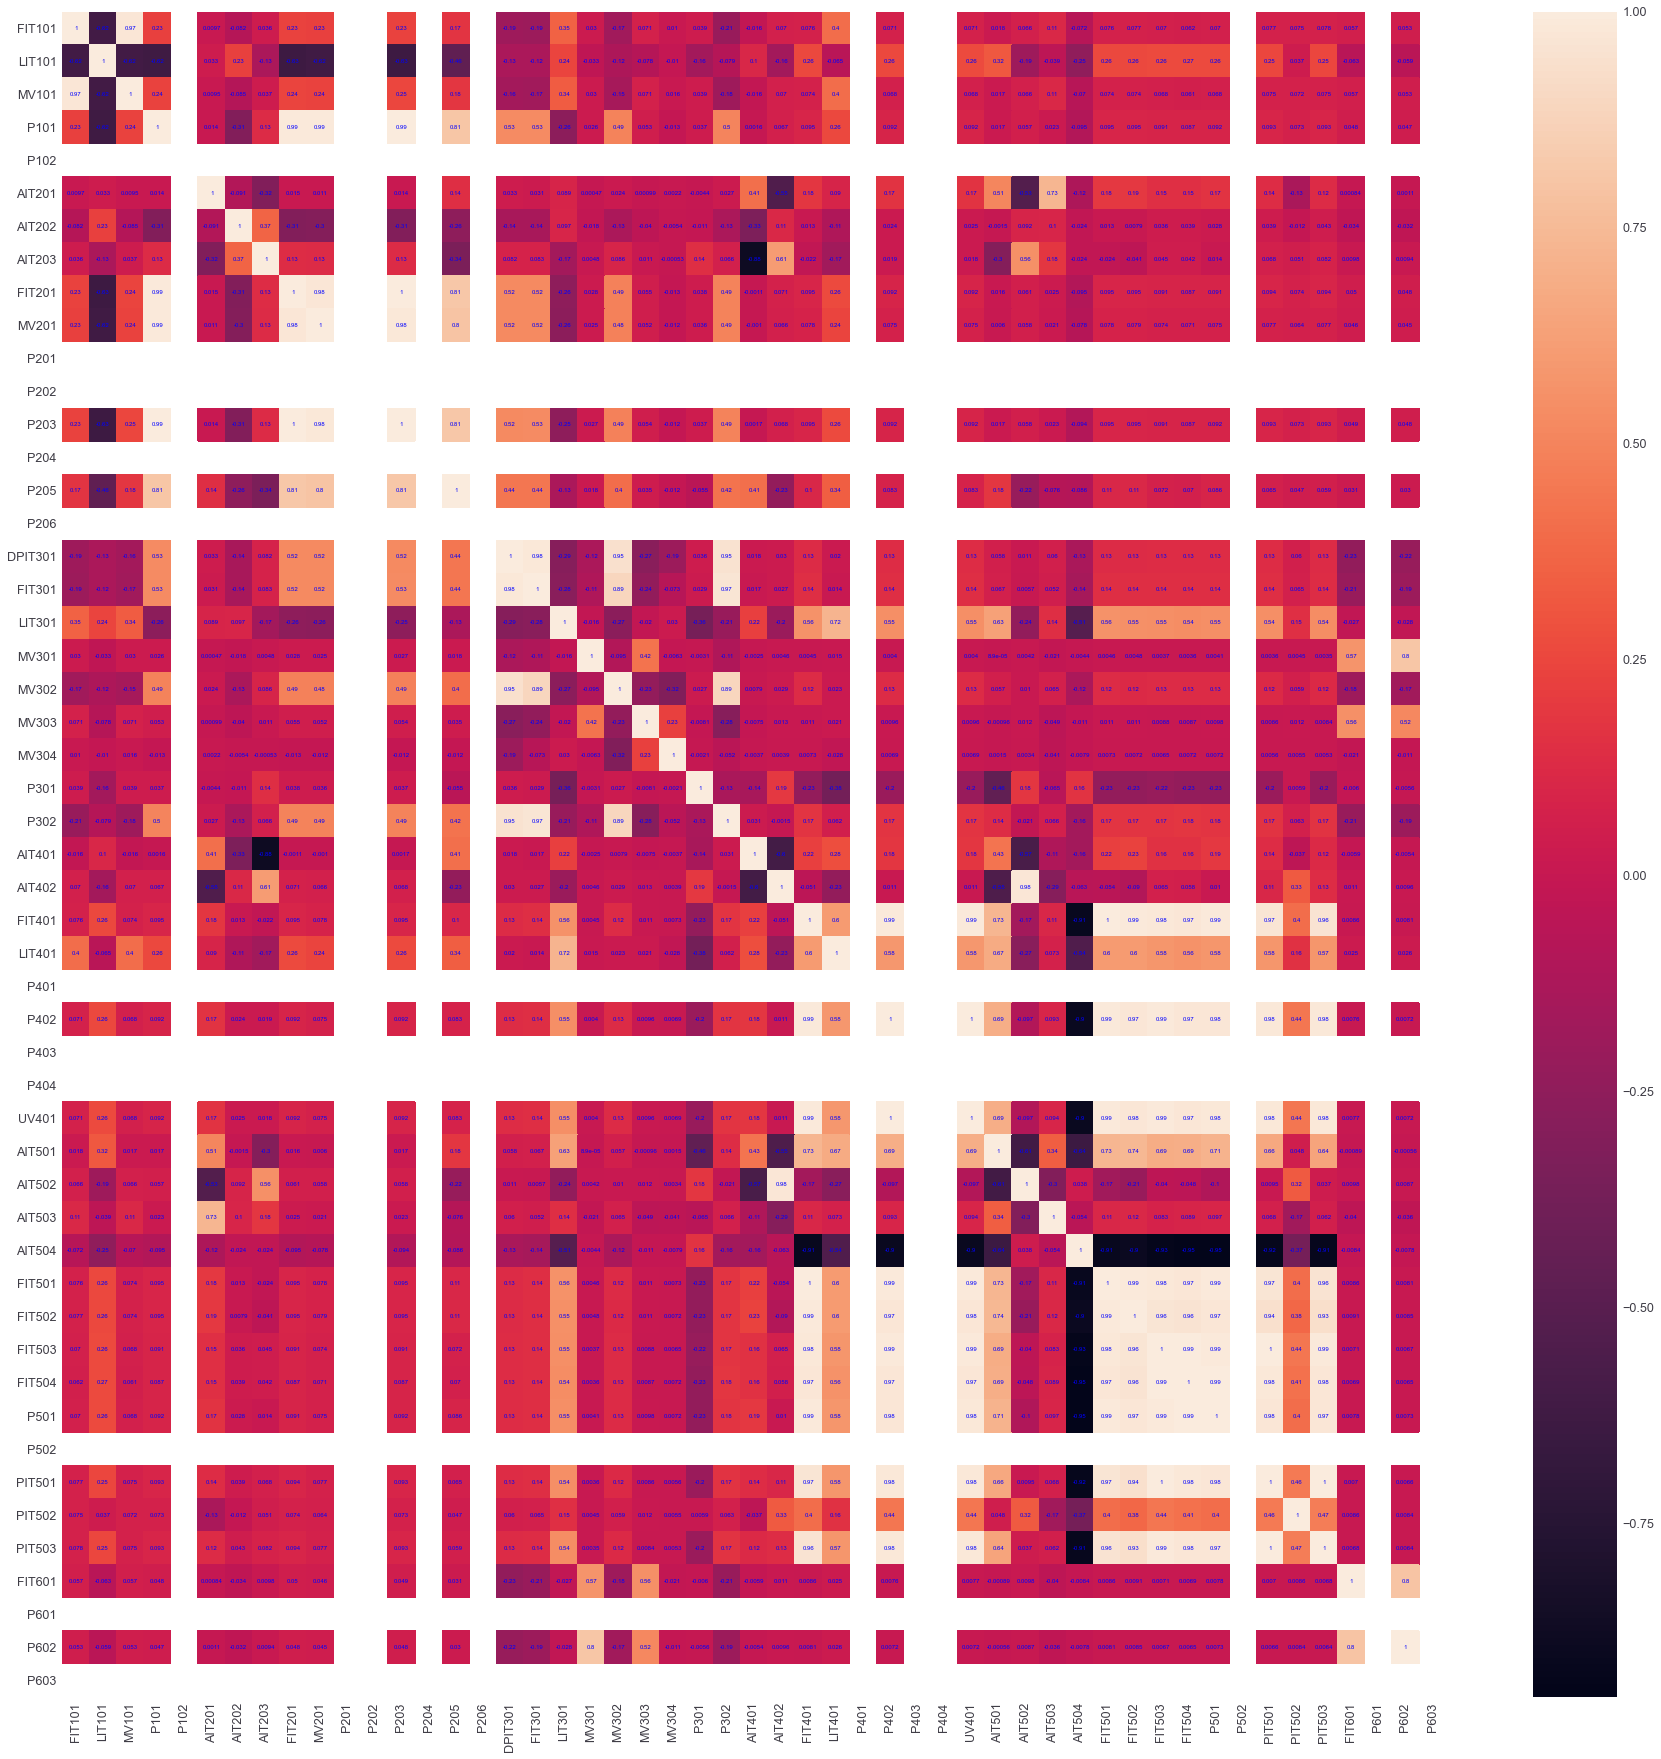

In [4]:
# to plot correlation matrix
corr = training_signals.corr()
plt.figure(figsize=(31,31))
sns.heatmap(corr, xticklabels=list(corr.columns), annot=True, yticklabels=list(corr.columns), annot_kws={'size':6,'color':'blue'})
plt.show()

In [5]:
def plot_signal(data,col,start=0,end=10000,title="",color="blue"):
	f,ax = plt.subplots(figsize=(22,3))
	f.suptitle(title)
	ax = sns.lineplot(data=data.loc[start:end,col],color=color)
	ax.set_xticks(range(start,end+1,5000))
	plt.show()	


Figure 3: perfectly correlated signals


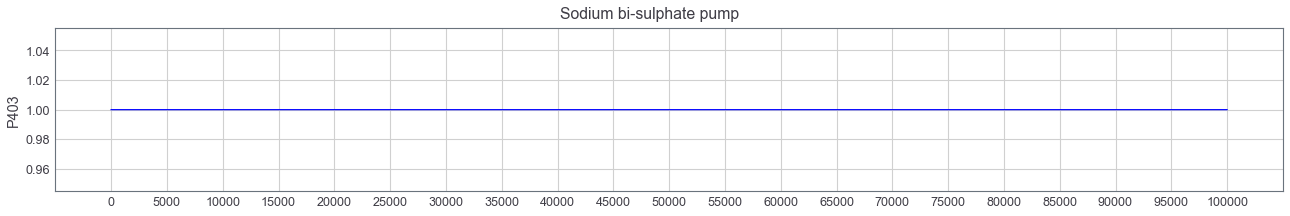

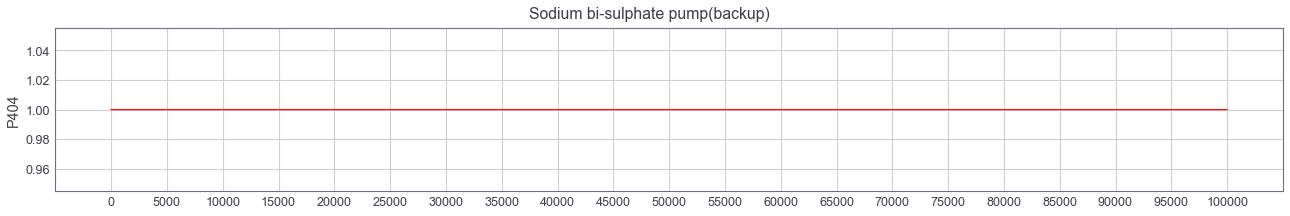


Figure 4: perfectly negatively correlated signals


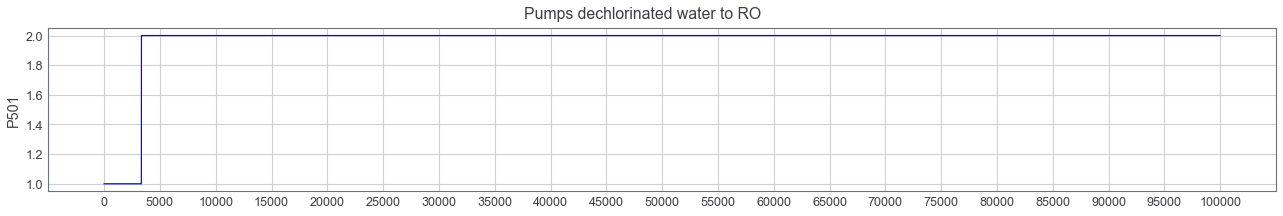

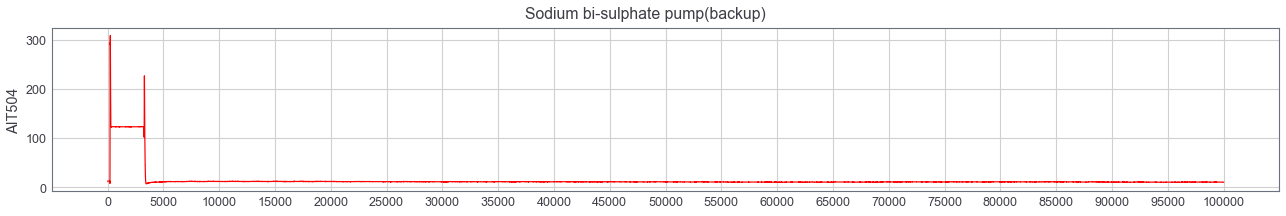

In [6]:
# Example of almost perfectly correlated signals
print("\nFigure 3: perfectly correlated signals")
plot_signal(training_signals,"P403",0,100000,"Sodium bi-sulphate pump","blue")
plot_signal(training_signals,"P404",0,100000,"Sodium bi-sulphate pump(backup)","red")

# Example of almost perfectly negatively correlated signals
print("\nFigure 4: perfectly negatively correlated signals")
plot_signal(training_signals,"P501",0,100000,"Pumps dechlorinated water to RO","blue")
plot_signal(training_signals,"AIT504",0,100000,"Sodium bi-sulphate pump(backup)","red")

In [7]:
# sliding_window for the forcast
def sliding_window(df, window_size, stride=1):
    N = np.floor((len(df) - window_size)/stride).astype(np.int)+1
    return_window = []
    for i in range(N):
        return_window.append(df[i*stride:i*stride+window_size])
    return np.array(return_window)

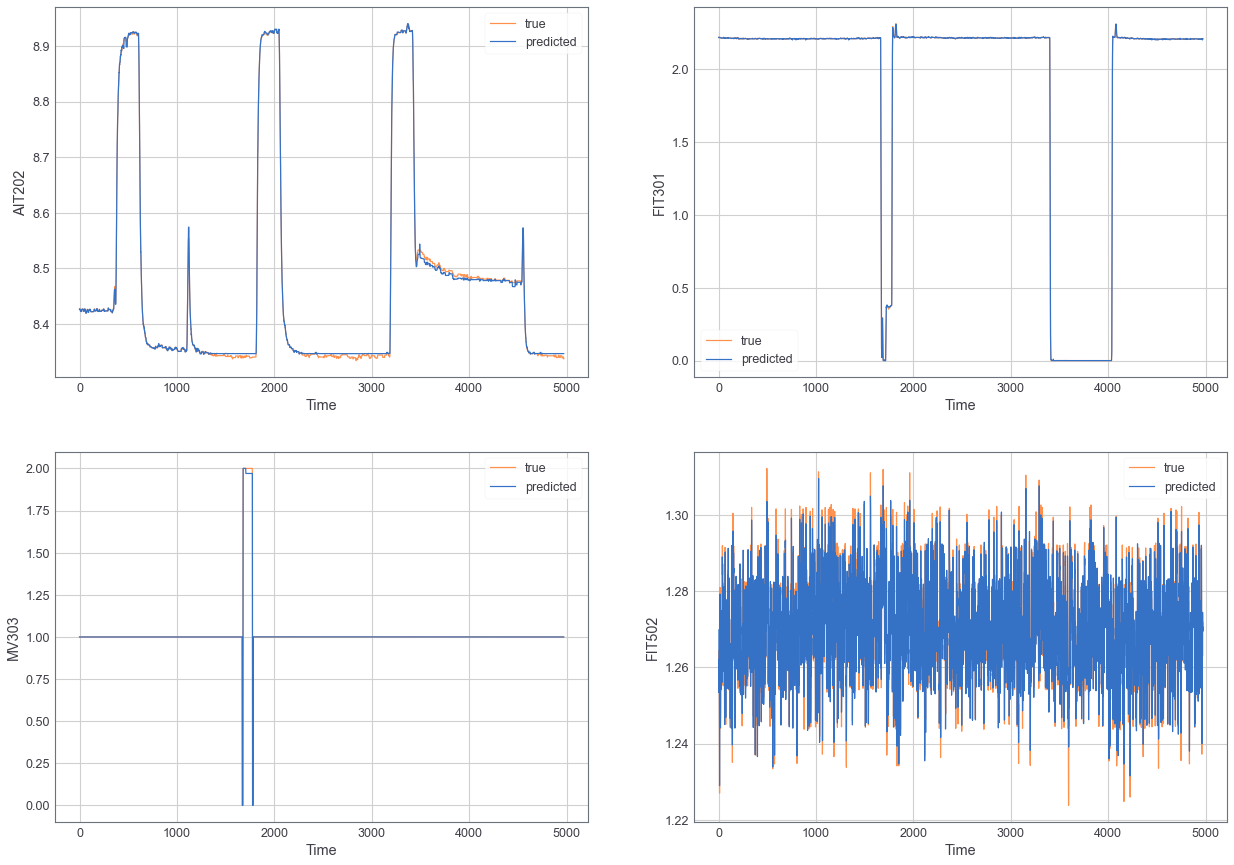

In [8]:
# applying sliding_window for ['AIT202', 'FIT301', 'MV303', 'FIT502']
columns_pred = ['AIT202', 'FIT301', 'MV303', 'FIT502']

window_size = 30
plt.figure(figsize=(21, 15))
i = 1
for col in columns_pred:
    # training
    training_col = training_signals.loc[10000:20000, col].copy()
    sw_training_col = sliding_window(
        training_col, window_size=window_size, stride=1)
    col_x = sw_training_col[:, :window_size-1]
    col_y = sw_training_col[:, window_size-1]
    rfr = RandomForestRegressor().fit(col_x, col_y)

    # testing
    tesing_col = training_signals.loc[20000:25000, col].copy()
    sw_testing_col = sliding_window(
        tesing_col, window_size=window_size, stride=1)
    test_col_x = sw_testing_col[:, :window_size-1]
    test_col_y = sw_testing_col[:, window_size-1]
    test_col_pred = rfr.predict(test_col_x)

    # plotting
    plt.subplot(2, 2, i)
    i += 1
    plt.plot(np.arange(len(test_col_y)), test_col_y, color='y')
    plt.plot(np.arange(len(test_col_pred)), test_col_pred, color='b')
    plt.legend(['true', 'predicted'])
    plt.xlabel('Time')
    plt.ylabel(col)
plt.show()

### 1b. Answers to the three questions

## 2. LOF task – 1/2 A4 – Individual

In [9]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_X.rename(columns=lambda x: x.strip(), inplace=True)
test_y = testing_label.copy()

### 2a. Plot LOF scores

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:28<00:00, 17.87s/it]


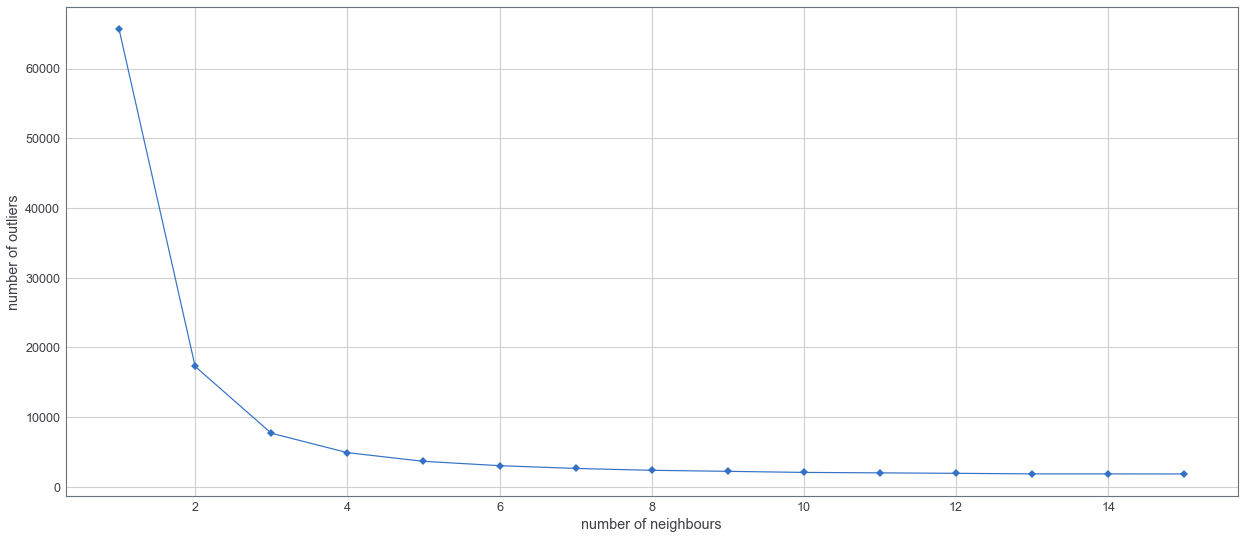

In [10]:
count_outlier = list()

for nn in tqdm(range(1,15+1)):
    lof = LocalOutlierFactor(n_neighbors=nn,
                             algorithm='kd_tree',
                             leaf_size=30, 
                             novelty=False, 
                             n_jobs=-1)
    training_result = lof.fit_predict(train_X)
    count_outlier.append(np.sum(training_result == -1))

plt.figure(figsize=(21,9))
plt.plot(np.arange(1,15+1), count_outlier, "-D")
plt.ylabel("number of outliers")
plt.xlabel("number of neighbours")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:05<00:00, 46.39s/it]


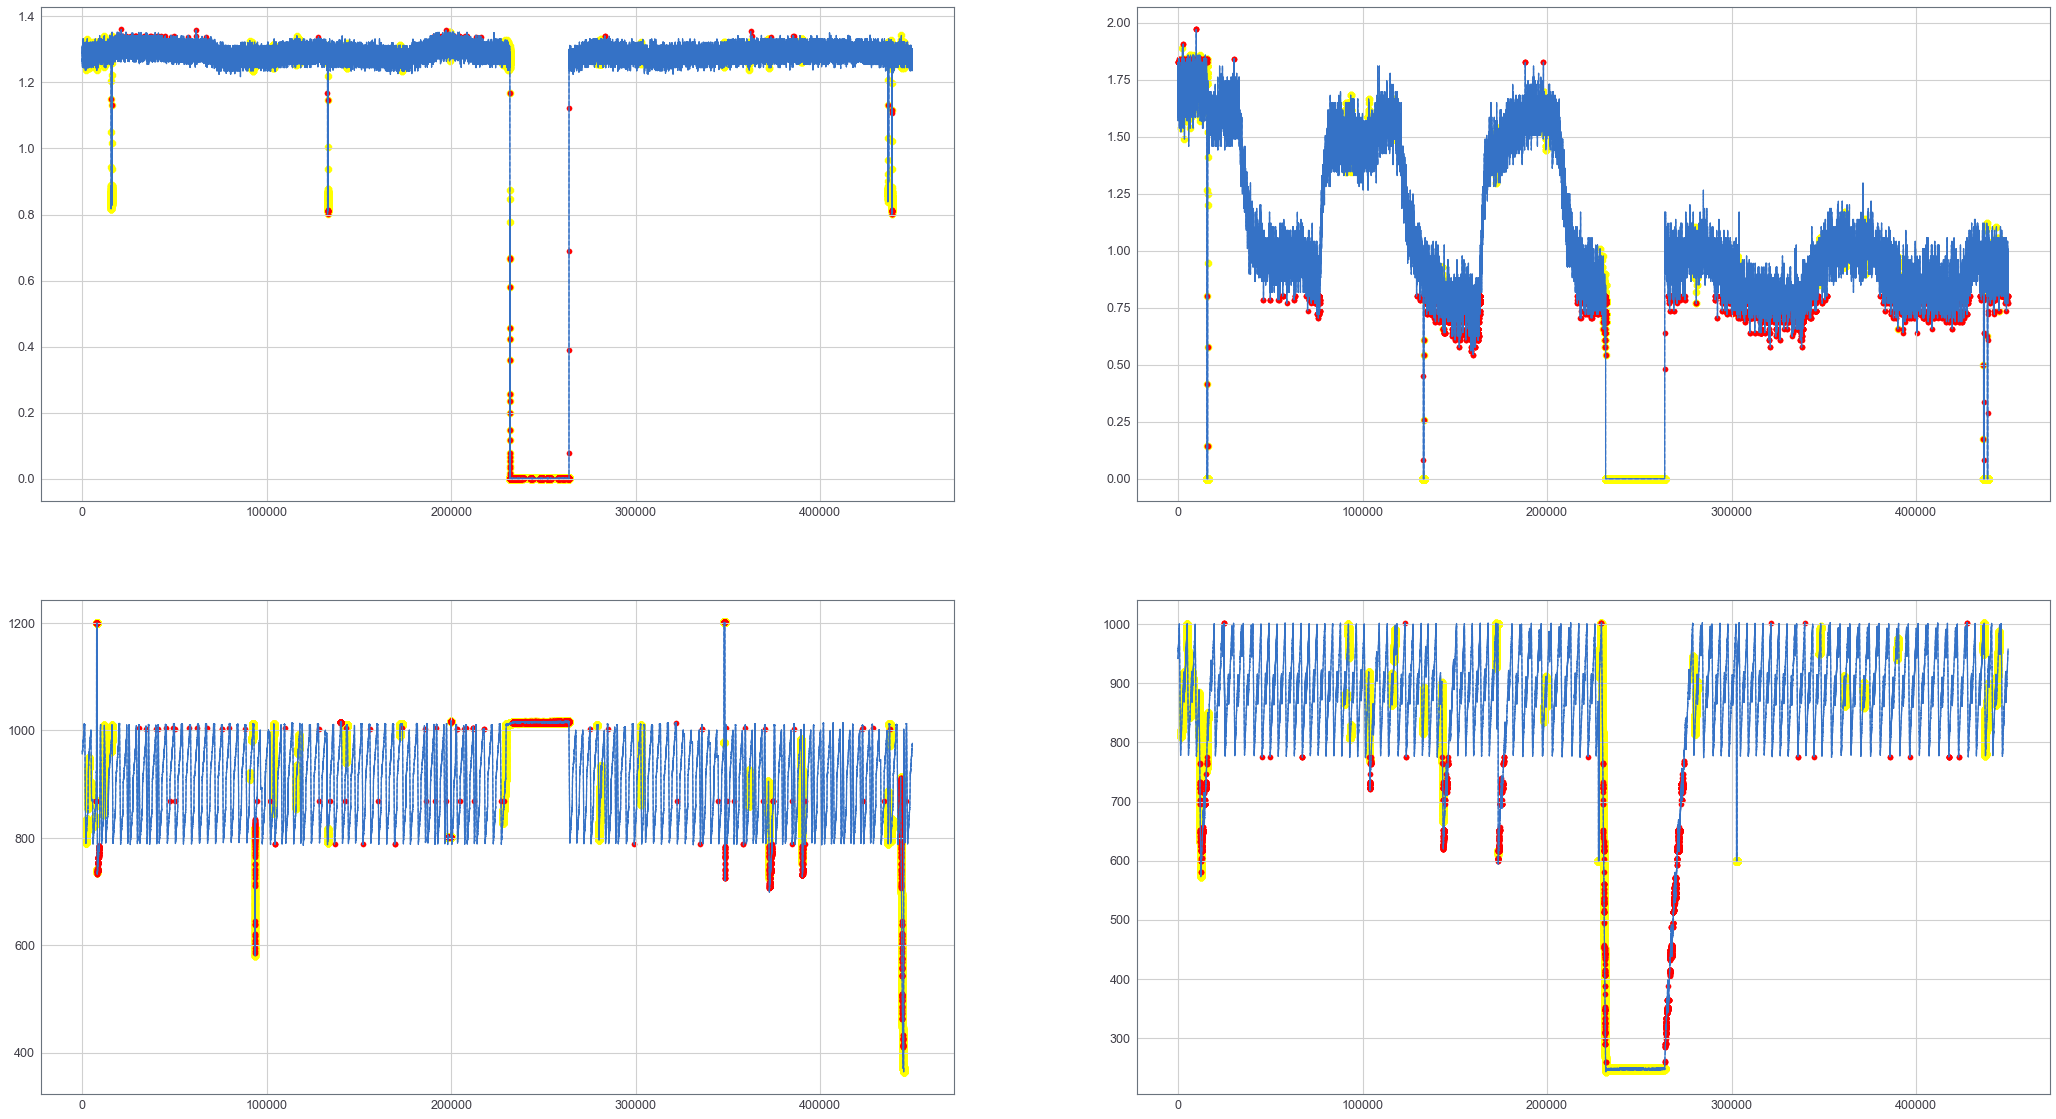

In [11]:
selected_signals = ['FIT502', 'PIT502', 'LIT301', 'LIT401']
y_pred_all = []
nn = [15,15,15,15]

plt.figure(figsize=(36, 20))
i = 1
for signal in tqdm(selected_signals):
    
    lof = LocalOutlierFactor(n_neighbors=nn[i-1],
                         algorithm='kd_tree',
                         leaf_size=100,
                         metric='minkowski',
                         p=1,
                         contamination="auto",
                         novelty=True,
                         n_jobs=-1)
    y_pred = lof.fit(train_X[signal].values.reshape(-1, 1)).predict(
        test_X[signal].values.reshape(-1, 1))

    plt.subplot(2, 2, i)
    i += 1
    plt.plot(test_X[signal])
    true_abn = np.where(test_y == 1)[0]
    pred_abn = np.where(y_pred == -1)[0]
    plt.plot(test_X[signal], '--b')
    plt.scatter(true_abn,
                test_X.loc[true_abn, [signal]],
                c='yellow',
                marker='8',
                s=60)
    plt.scatter(pred_abn,
                test_X.loc[pred_abn, [signal]],
                c='red',
                marker='o',
                s=30)
    y_pred_all.append(y_pred)

plt.show()

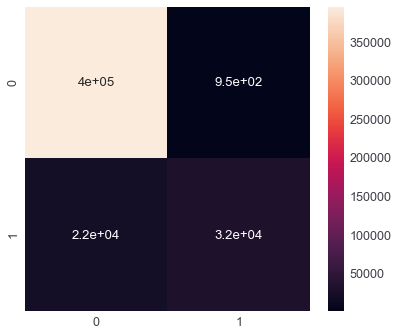

In [12]:
test_pred = y_pred_all[2] == -1
cm = confusion_matrix(test_y, test_pred)
f = sns.heatmap(cm, annot=True)

### 2b. Analysis and answers to the questions

#### Do you see large abnormalities in the training data?
The number of abnormalities relies on the number of neighbors that are chosen to estimate a sample point. If the neighbors are few, a great number of sample points will be sentenced to be outliers, but with the increase of neighbors, the number of abnormalities in the training set becomes less. The number of neighbors cannot be set too large, as it will be less sensitive to the truth outliers in the testing set. However, the number cannot be set too small either, as it will become too sensitive to the local changes.

#### Can you explain why these occur?
Even in the data set where no abnormalities are included, some segments in the signals may still not rigorously follow the normal behaviors. In consequence, some points may form outlier clusters in which points are normal but are abnormal globally when taking all segments into consideration.

#### It is best to remove such abnormalities from the training data since you only want to model normal behavior?
If a pattern that is normal shows abnormal in the training set, when a similar pattern appears in the testing set, the similar one would be predicted as an abnormality because the pattern originally in the training set is sentenced to be abnormal. If the same pattern is removed from the training set, when a similar pattern appears in the testing set, this coming one would be predicted as an abnormality because the model has no idea about this "new" pattern. Therefore, deleting the abnormalities in the training set seems to impact less on the predictions.

#### What kind of anomalies can or can you not detect using LOF?
LOF can detect point anomalies by measuring the local deviation of density for a given sample with respect to its neighbors. Point anomaly is defined as "*A single instance of data that is anomalous since it deviates largely from the rest of the data points*" which is consistent with the measurement of LOF - *how isolated the object is with respect to the surrounding neighborhood*.

## 3. PCA task – 1/2 A4 – Individual

In [13]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 3a. Plot PCA residuals

In [14]:
# decide n_components
# to normalize the training data
normalizer = Normalizer().fit(train_X)
train_X_norm = normalizer.transform(train_X)

res = []
for n_components in np.arange(5, 25+1):
    # pca
    pca = PCA(n_components=n_components).fit(train_X_norm)

    # pca forward transform
    train_X_pca = pca.transform(train_X_norm)

    # pca backward transform
    train_X_invpca = pca.inverse_transform(train_X_pca)

    # compute residual
    res.append(np.linalg.norm(train_X_norm - train_X_invpca, ord=2, axis=1))
    
    print('>', end='')

>>>>>>>>>>>>>>>>>>>>>

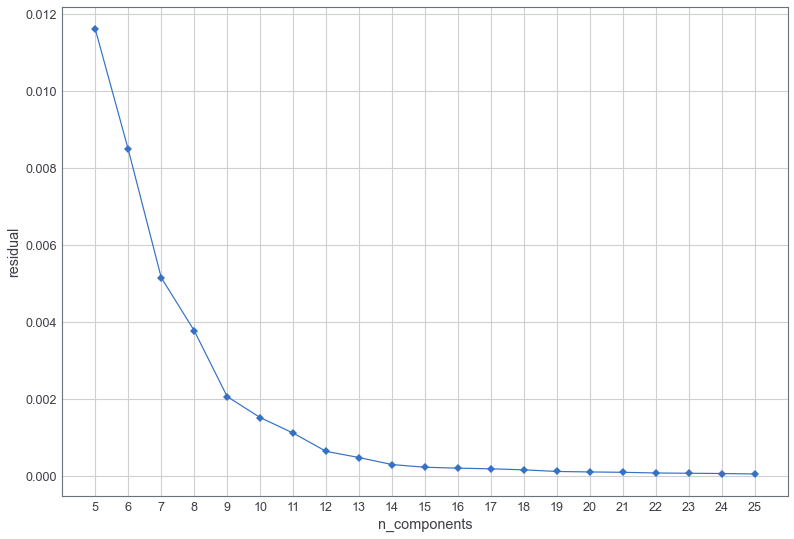

In [15]:
# plot residual ~ n_components
plt.figure(figsize=(13, 9))
plt.plot(np.arange(5, 25+1), np.mean(res, axis=1), '-D')
plt.xticks(ticks=np.arange(5, 25+1))
plt.ylabel('residual')
plt.xlabel('n_components')
plt.show()

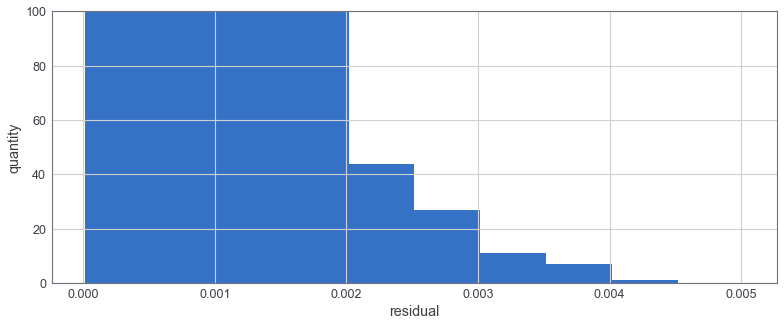

In [16]:
# box-plot to visualize the distribution
plt.figure(figsize=(13, 5))
plt.hist(res[12], range=[np.min(res[12]), np.max(res[12])+0.001])
plt.xlabel('residual')
plt.ylabel('quantity')
plt.ylim([0,100])
plt.show()

In [17]:
n_components = 12
threshold = 0.004

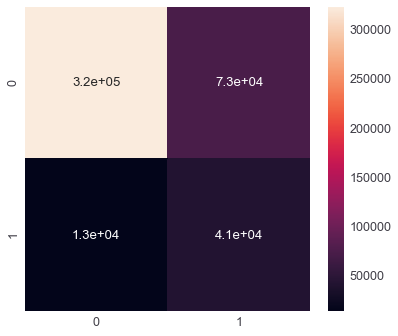

In [18]:
# build pca
pca = PCA(n_components=n_components).fit(train_X_norm)

# normalize testing data
test_X_norm = Normalizer().transform(test_X)

# forward pca
test_X_pca = pca.transform(test_X_norm)

# backward pca
test_X_invpca = pca.inverse_transform(test_X_pca)

# prediction
test_pred = np.linalg.norm(test_X_norm-test_X_invpca, ord=2, axis=1) > threshold

# confusion matrix
cm = confusion_matrix(test_y, test_pred)
f = sns.heatmap(cm, annot=True)

### 3b. Analysis and answers to the questions

#### Do you see large abnormalities in the training data? Can you explain why these occur?
Using PCA to detect the anomaly is quite similar to auto-encoder. PCA, trained by the training set, is used for reducing the feature dimensions of samples and recovering them back. If the samples can be recovered from the loss compression, they obey normal structure and are normal data; otherwise, they are abnormalities. In this situation, the recovering threshold is quite important to decide whether the recovered points belong to normal ones. If the threshold is set too small, it will have a considerable amount of abnormalities in the training data. Thus, in order to make the judgment of anomaly fair, the threshold should be set suitable large. 

#### It is best to remove such abnormalities from the training data since you only want to model normal behavior?
If the abnormalities are removed from the training data, we will have no idea where to put the threshold. The abnormalities in the training data tell people which points cannot be recovered back. 

#### What kind of anomalies can or can you not detect using PCA?
PCA detects point outliers that have an obviously different variance than the regular distribution in the direction of the principal components.

## 4. ARMA task – 1/2 A4 - Individual

In [60]:
ARMA_SIGNALS = ['AIT504', 'LIT101', 'LIT301', 'AIT202', 'AIT402']

train_X = training_signals[ARMA_SIGNALS].copy()
train_y = training_label.copy()
test_X = testing_signals[ARMA_SIGNALS].copy()
test_y = testing_label.copy()

### 4a. Print relevant plots and/or metrics to determine the parameters.

AIT504


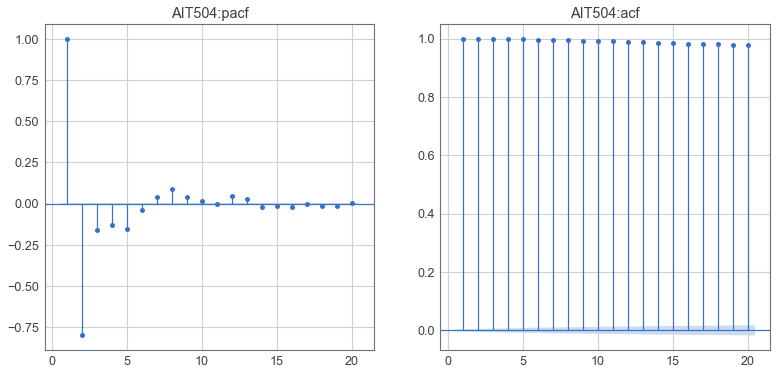

LIT101


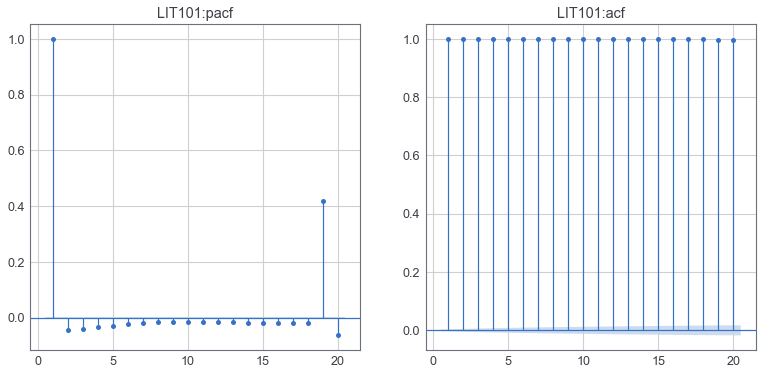

LIT301


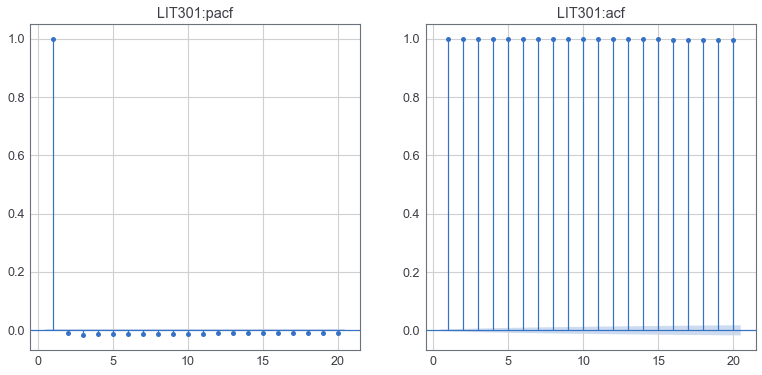

AIT202


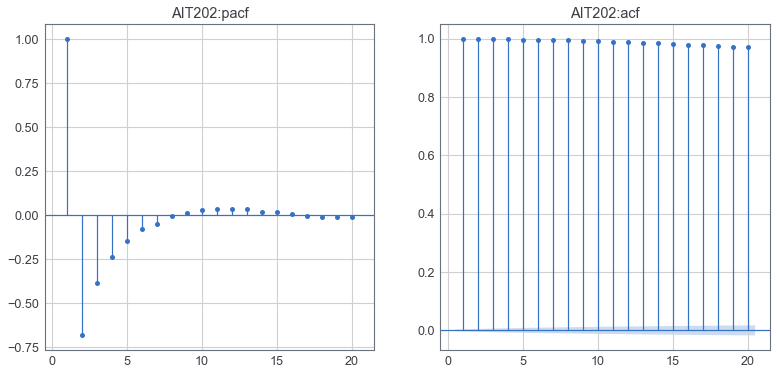

AIT402


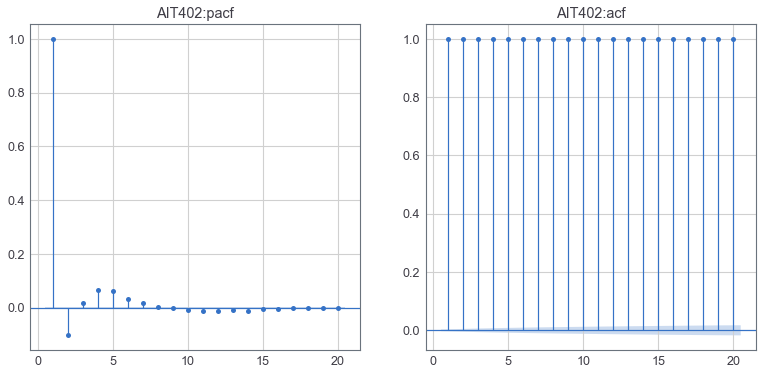

In [20]:
for signal in ARMA_SIGNALS:
    print(signal)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    plot_acf(train_X[signal], lags=20, zero=False, ax=ax2, title=signal+":acf")
    plot_pacf(train_X[signal], lags=20, zero=False, ax=ax1, title=signal+":pacf")
    plt.show()

In [21]:
# select the model with lowest aic
p_range = range(0,3) 
q_range = range(0,3) 
d_range = range(0,2)

best_order = []

for signal in ARMA_SIGNALS:
    sub_train_X = train_X[signal].copy()
    aic = np.inf 
    order = None
    arima = None
    for i in p_range:
        for j in q_range:
            for d in d_range:
                    temp_model = ARIMA(sub_train_X[12000:16000], order=(i,d,j)).fit()
                    temp_aic = temp_model.aic
                    if temp_aic < aic:
                        aic = temp_aic
                        order = (i, d, j)
                        arima = temp_model
    print('Best order for '+signal, order)
    best_order.append(order)

Best order for AIT504 (2, 1, 1)
Best order for LIT101 (2, 1, 2)
Best order for LIT301 (2, 1, 2)
Best order for AIT202 (2, 1, 2)
Best order for AIT402 (2, 1, 2)


In [22]:
# To make things simpler, the best order is set to (2,1,2)
best_order = (2,1,2)

### 4b. Plots to study the detected anomalies

AIT504


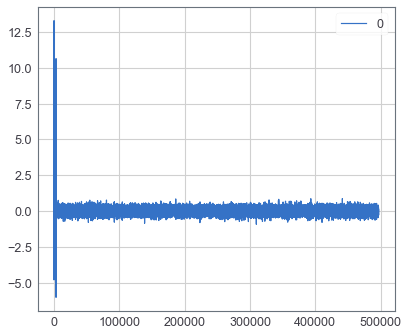

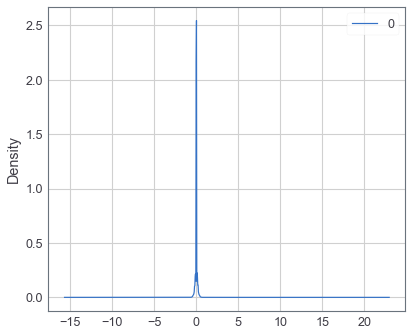

                   0
count  496800.000000
mean        0.000025
std         0.085668
min        -6.028413
25%        -0.000002
50%         0.000000
75%         0.000002
max        13.303129
LIT101


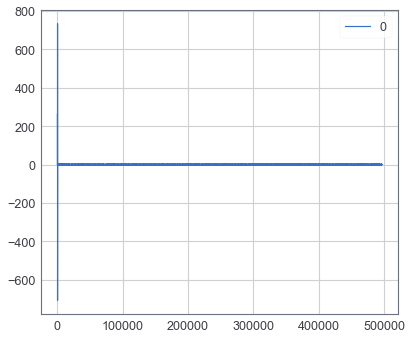

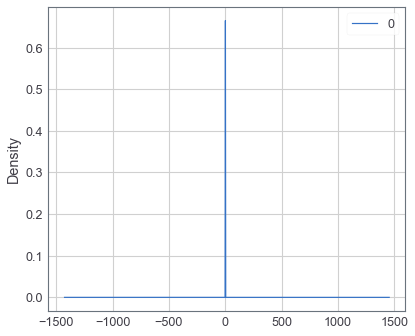

                   0
count  496800.000000
mean        0.000977
std         1.558286
min      -706.660636
25%        -0.262015
50%        -0.000175
75%         0.258980
max       733.263954
LIT301


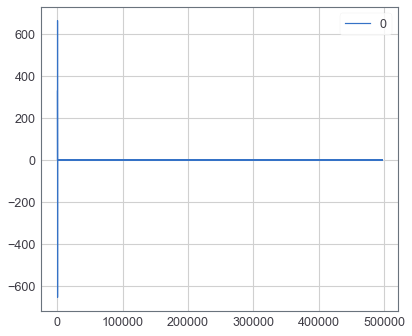

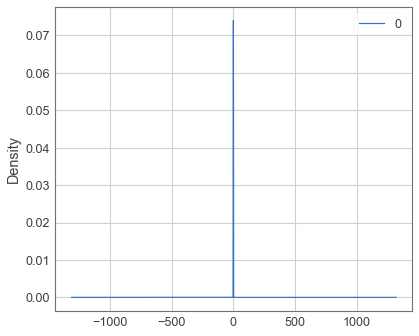

                   0
count  496800.000000
mean        0.001069
std         1.427365
min      -652.986380
25%        -0.185516
50%        -0.005346
75%         0.178419
max       662.313951
AIT202


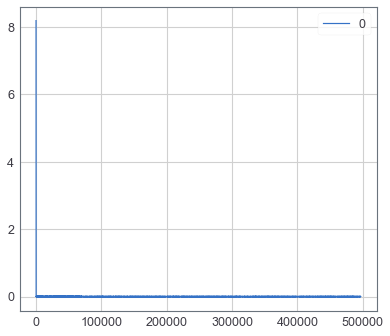

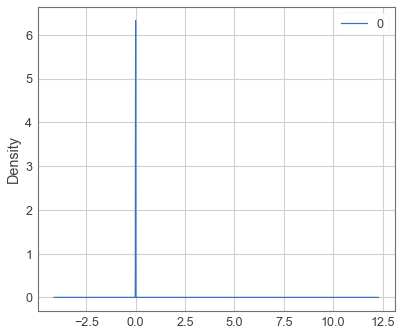

                   0
count  496800.000000
mean        0.000017
std         0.011656
min        -0.024316
25%        -0.000087
50%         0.000000
75%         0.000089
max         8.190080
AIT402


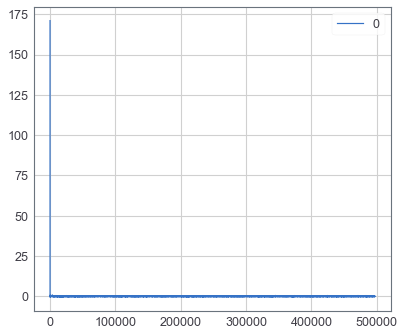

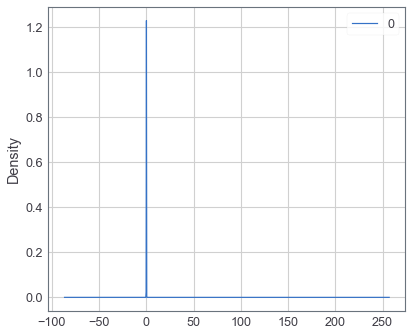

                  0
count  4.968000e+05
mean   3.119947e-04
std    2.466186e-01
min   -7.284232e-01
25%   -4.793277e-04
50%    1.421085e-13
75%    5.758788e-04
max    1.710587e+02


In [31]:
for signal in ARMA_SIGNALS:
    print(signal)
    series = train_X[signal].copy()
    # fit model
    model = ARIMA(series, order=best_order)
    model_fit = model.fit()
    # summary of fit model
    # print(model_fit.summary())
    # line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())

The following cell is the training and predicting process which is time-consuming. You can uncomment it and run by yourself.

In [32]:
# for signal in ARMA_SIGNALS:
#     print(signal)
#     sub_train_X = train_X[signal].copy()
#     sub_test_X = test_X[signal].copy()
#     train, test = sub_train_X[10000:20000].values, sub_test_X[11410-250:11410+50].values
#     label = test_y[11410-250:11410+50]
#     history = [x for x in train]
#     predictions = list()
#     # walk-forward validation
#     for t in tqdm(range(len(test))):
#         model = ARIMA(history, order=best_order)
#         model_fit = model.fit()
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test[t]
#         history.append(obs)
# #         print('predicted=%f, expected=%f' % (yhat, obs))
#     # evaluate forecasts
#     np.save("./arma/prediction_"+signal+".npy", predictions)
#     rmse = np.sqrt(mean_squared_error(test, predictions))
#     print('Test RMSE: %.3f' % rmse)
#     # plot forecasts against actual outcomes
#     plt.figure(figsize=(13,6))
#     plt.plot(test, "--b")
#     plt.plot(predictions, '-.r')
#     plt.title("Evaluation ARIMA")
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.legend(['original', 'predicted'])
#     plt.show()

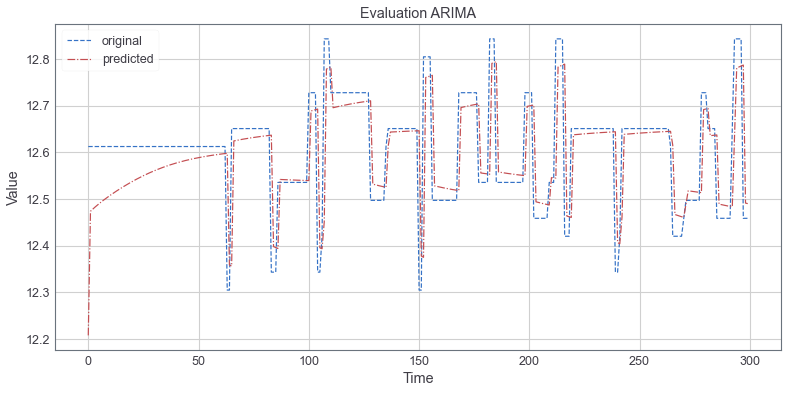

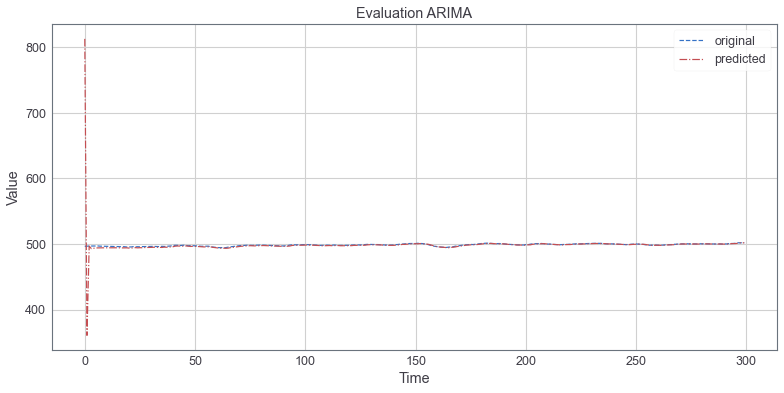

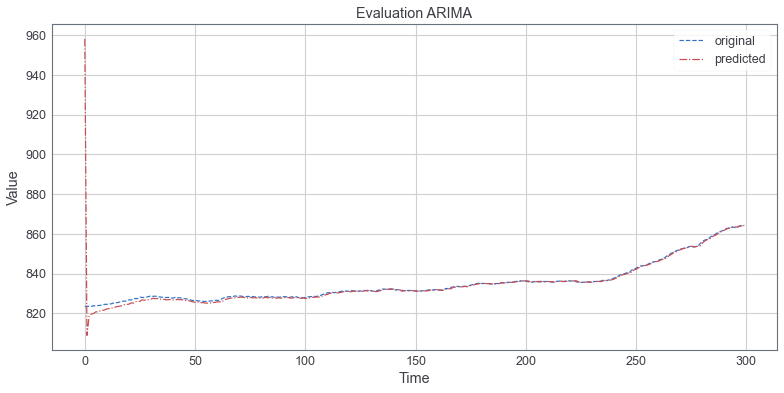

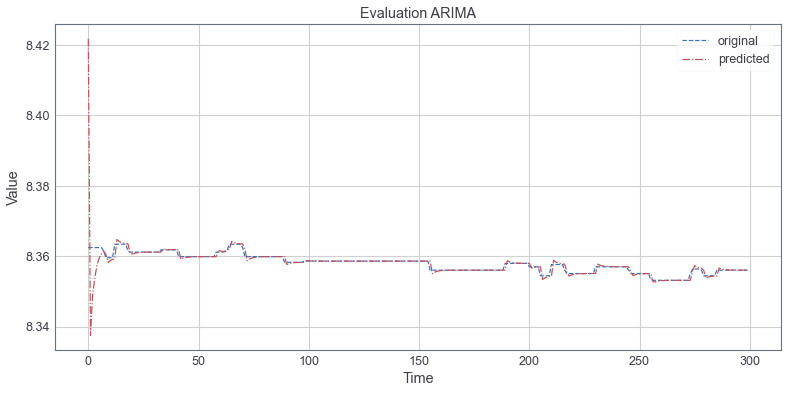

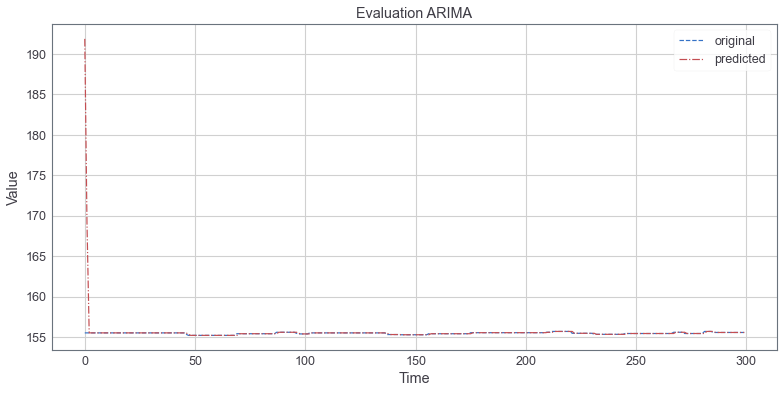

In [33]:
for signal in ARMA_SIGNALS:
    temp_signal = np.load('./arma/prediction_' + signal + '.npy')
    sub_test_X = test_X[signal].copy()
    test = sub_test_X[11410-250:11410+50].values
    # plot forecasts against actual outcomes
    plt.figure(figsize=(13, 6))
    plt.plot(test, "--b")
    plt.plot(temp_signal, '-.r')
    plt.title("Evaluation ARIMA")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(['original', 'predicted'])
    plt.show()

In [118]:
selected_signal = np.load('./arma/prediction_AIT504.npy')
selected_original = test_X.loc[11410-250:11410+50-1, ['AIT504']].values.reshape(-1,)
threshold = 0.01
selected_signal_pred = (selected_signal - selected_original) > threshold
selected_signal_label = test_y[11410-250:11410+50]
confusion_matrix(selected_signal_label, selected_signal_pred)

array([[190,  60],
       [ 27,  23]], dtype=int64)

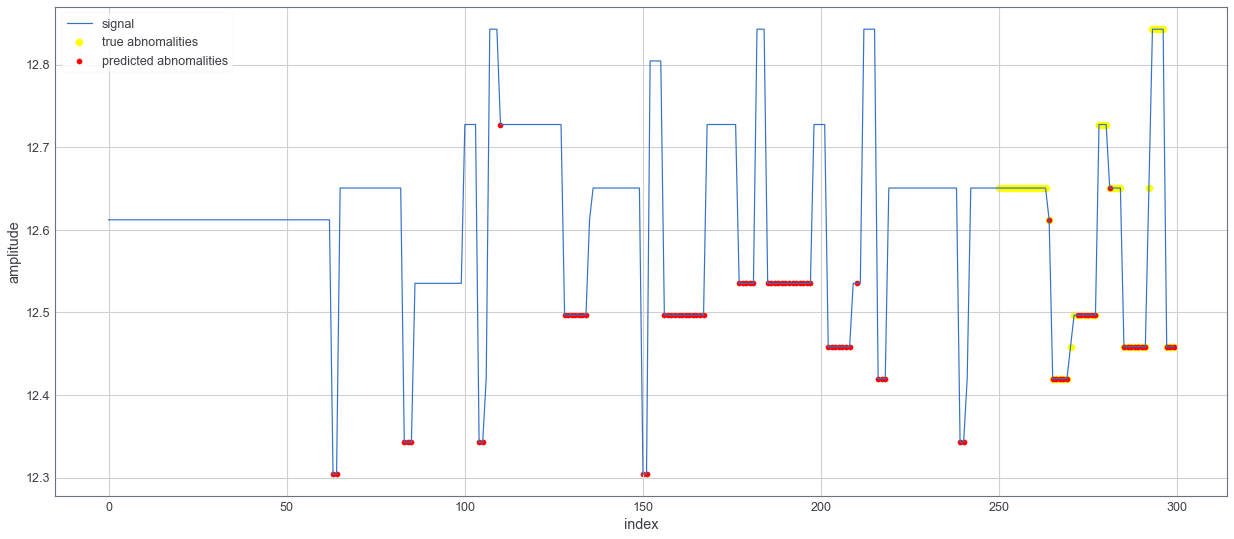

In [129]:
pred_abn = np.where(selected_signal_pred==1)[0]
true_abn = np.where(selected_signal_label==1)[0]
plt.figure(figsize=(21,9))
plt.plot(selected_original)
plt.scatter(true_abn, selected_original[true_abn], c='yellow', marker='8', s=60)
plt.scatter(pred_abn, selected_original[pred_abn], c='red', marker='o', s=30)
plt.xlabel('index')
plt.ylabel('amplitude')
plt.legend(['signal', 'true abnomalities', 'predicted abnomalities'])
# plt.savefig('./figures/arima_res.png', dpi=600)
plt.show()

### 4c. Analysis and answers to the questions

#### What kind of anomalies can / can you not detect using ARMA models?
ARMA has the ability to identify contextual anomalies because ARMA regress on previous values then uses them to predict the next value. According to its results, we observed that when the tendency of the predicting signal gradually changes, ARMA can abide by the signal well, but when there is a sudden change, it cannot perfectly catch and follow this change. Since ARMA is quite sensitive to local change, it is suitable for detecting contextual anomalies. 

#### Which sensors can be modeled effectively using ARMA?
The prediction using ARMA is quite time-consuming. In this task, we adopted ARMA as an off-line model - given training set and to predict testing set. However, we think ARMA is much better to be designed as an online model. ARMA is quite suitable for the sensors which monitor the moderately changing signals such as AIT402, AIT501, and AIT502. Other signals like MV301 are not appropriate for it, since it often alarms abnormalities for them when observes dramatic changes. 

## 5. N-gram task – 1/2 A4 - Individual

In [34]:
def dicretize_data(signal, discretize_groups):
    # Initiliaze arrays
    label_classes = []
    step_sizes = []

    # Compute min and max value of signal to compute the stepsize
    min_value = min(signal)
    max_value = max(signal)
    step_size = (max_value - min_value) / discretize_groups

    bins = []
    bins.append(min_value)
    # Create bins
    for i in range(discretize_groups):
        label_classes.append(i)
        bins.append(bins[i] + step_size)

    # Use digitize method to discretize the signal
    return np.digitize(signal, bins), bins

### 5a. Visualise discretization

In [35]:
# discretize
def plot_discretize(ngram_signal):
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    plt.figure(figsize=(21,9))
    plt.title("Training Set")
    plt.subplot(121)
    plt.plot(np.unique(train_X,return_counts=True)[0], np.unique(train_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(train_X_discrete,return_counts=True)[0], np.unique(train_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')

    plt.figure(figsize=(21,9))
    plt.title("Testing Set")
    plt.subplot(121)
    plt.plot(np.unique(test_X,return_counts=True)[0], np.unique(test_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    test_X_discrete = np.digitize(test_X, train_bins)
    # train_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(test_X_discrete,return_counts=True)[0], np.unique(test_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')
    plt.show()

In [36]:
ngram_signals = ['LIT101', 'LIT301', 'AIT202', 'AIT402', 'AIT503']

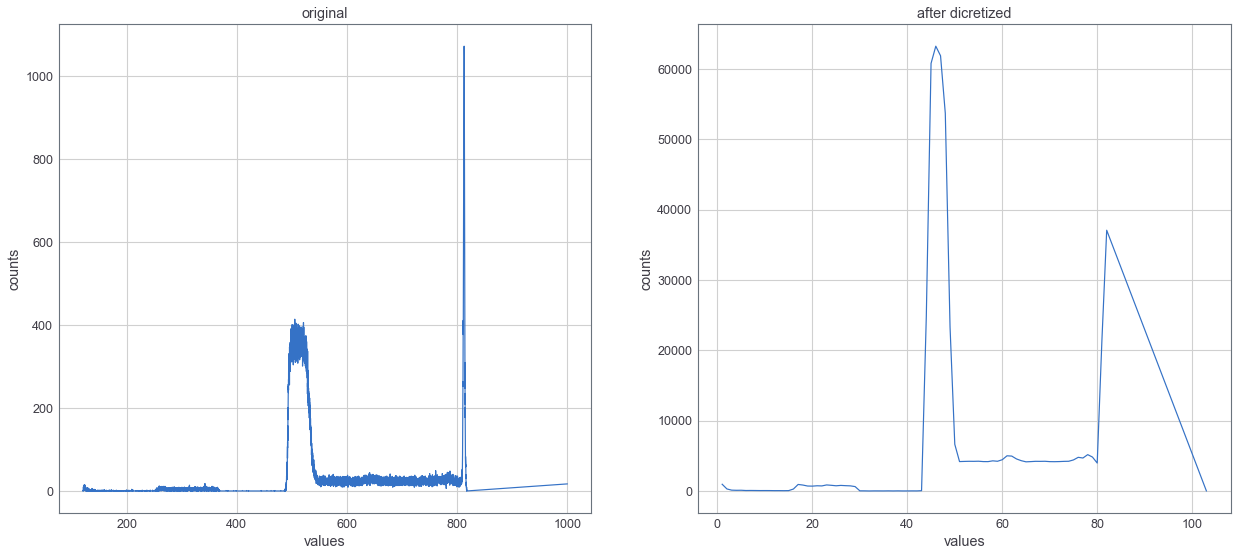

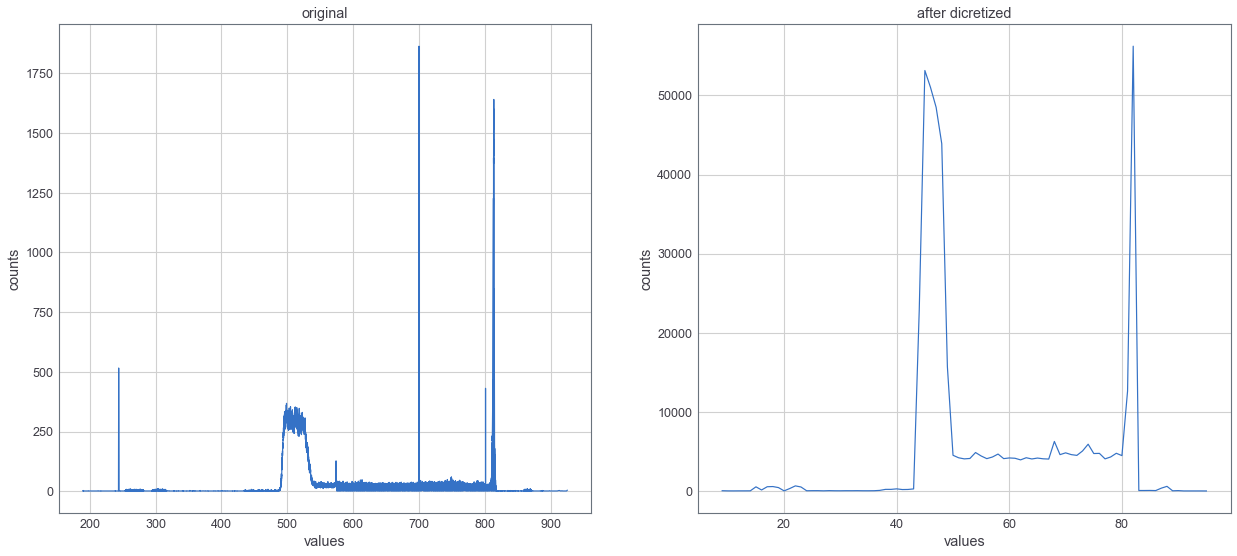

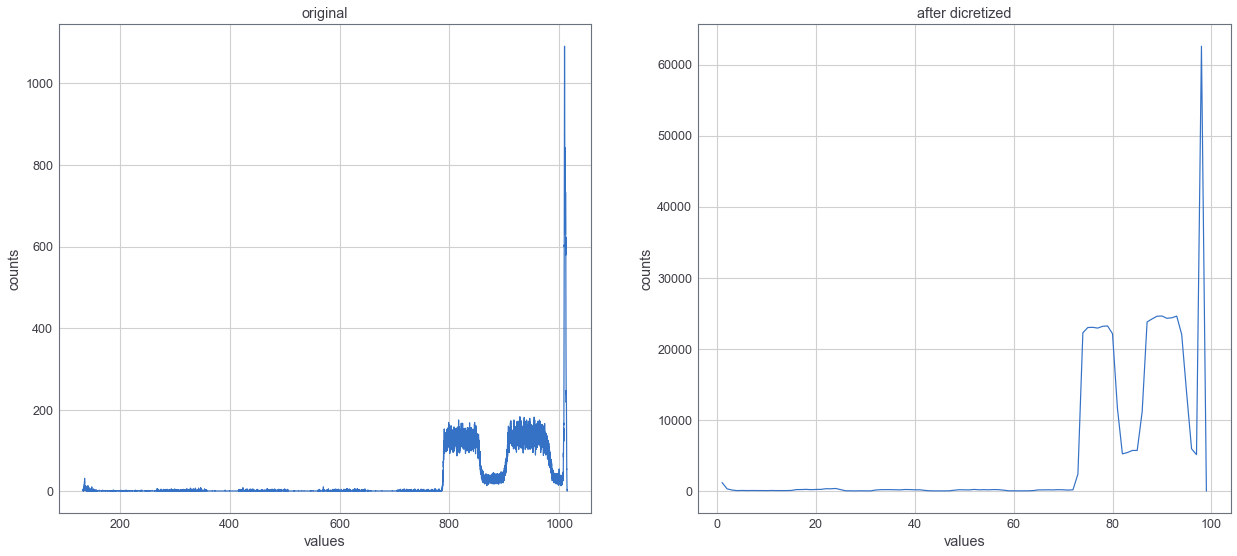

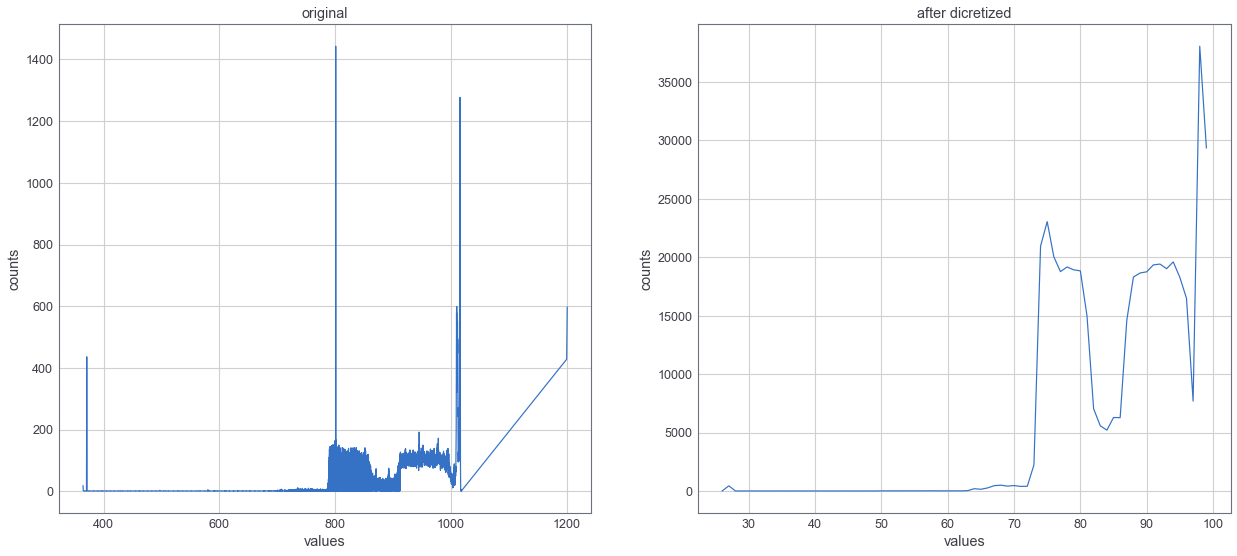

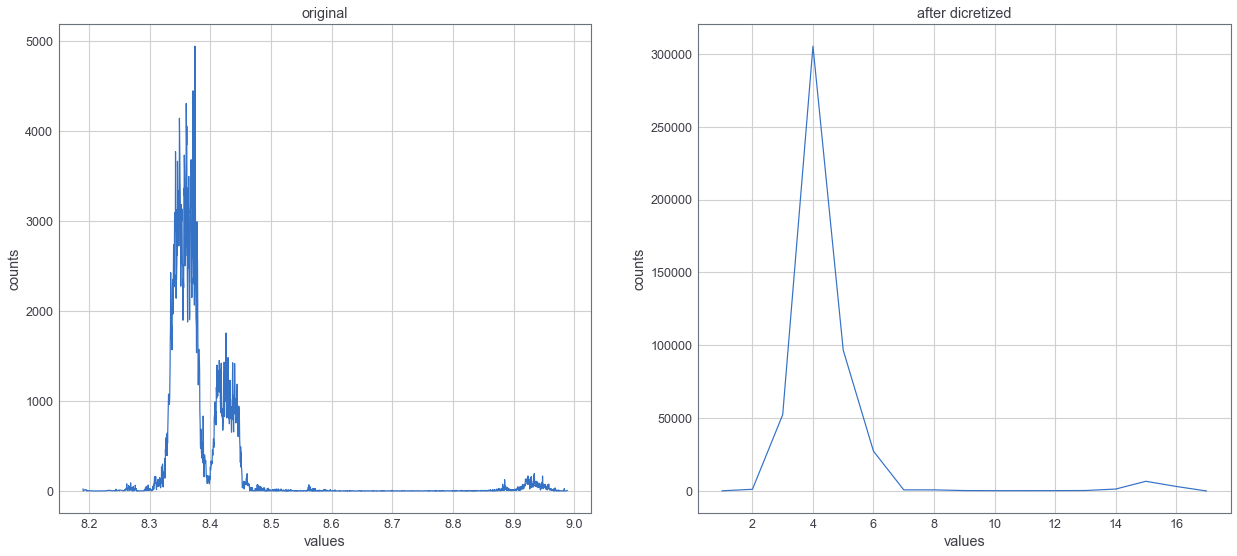

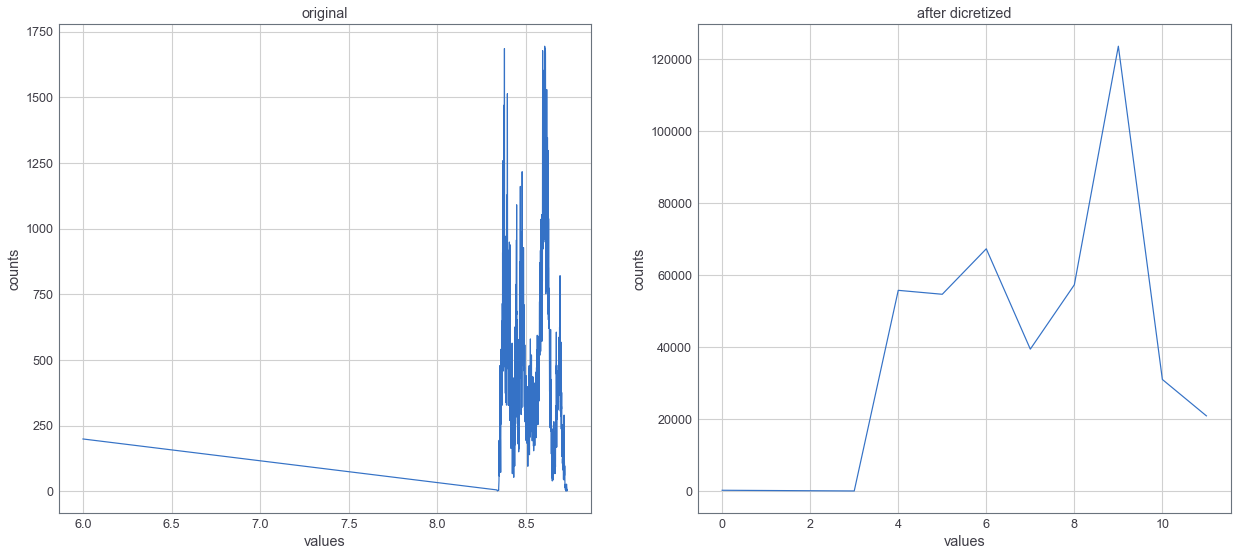

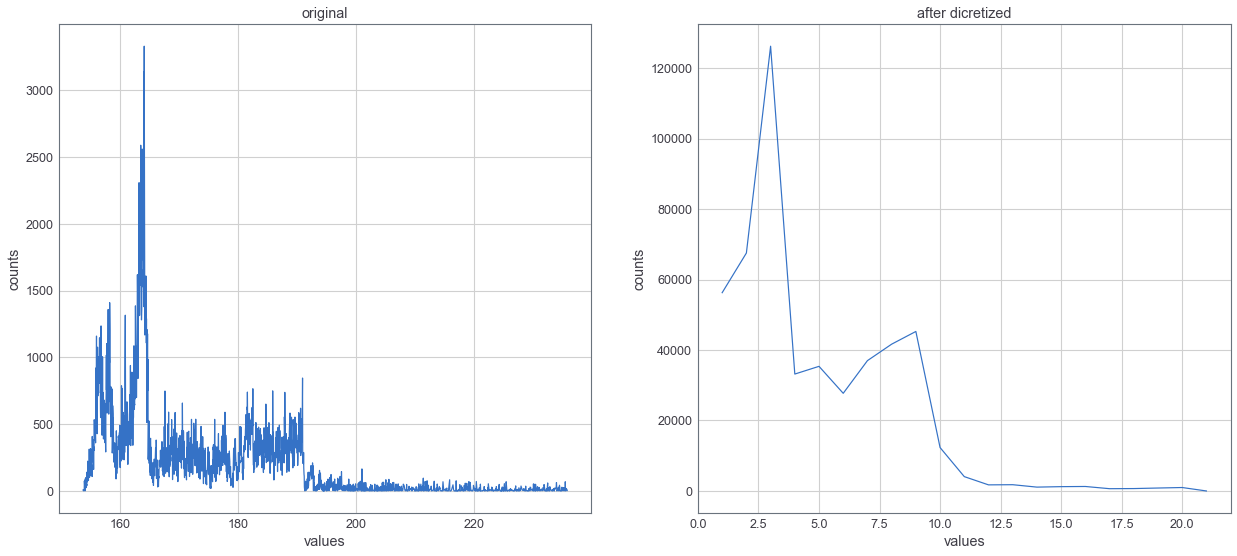

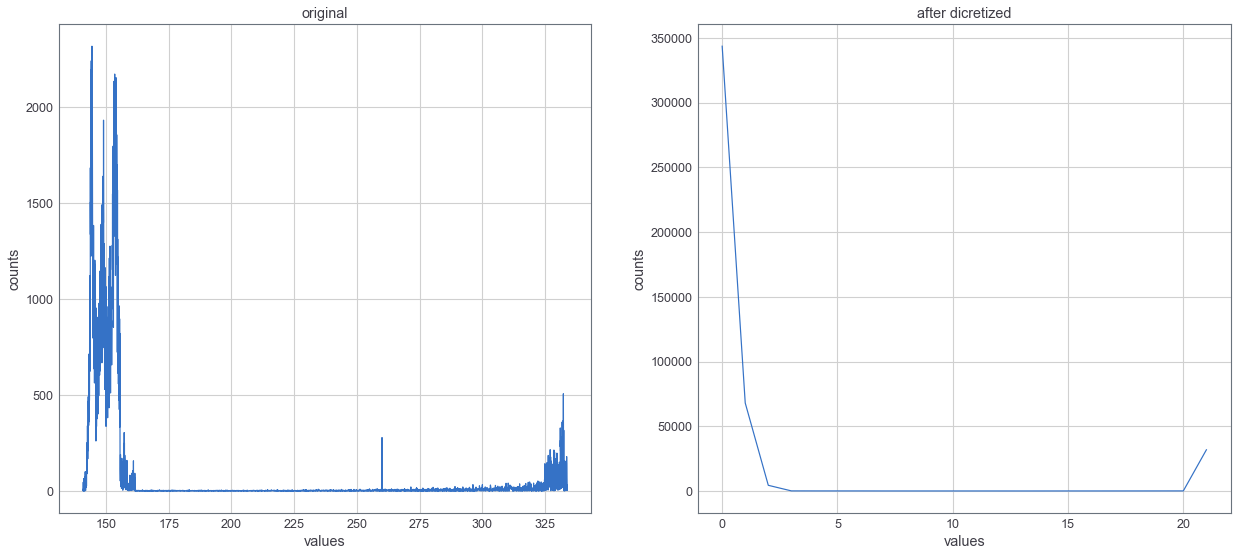

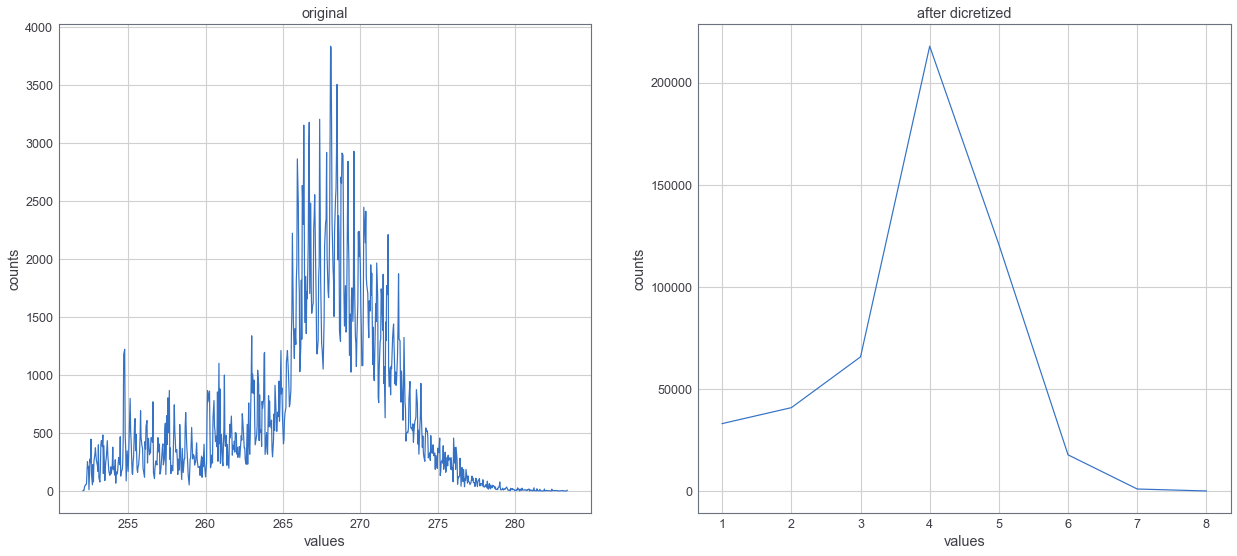

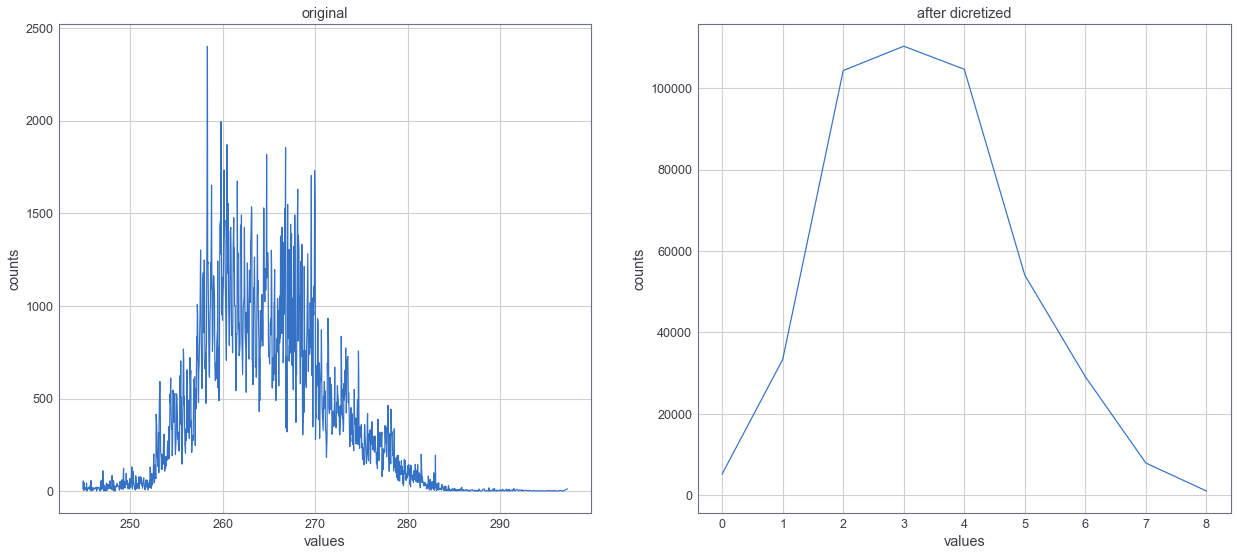

In [37]:
for ngram_signal in ngram_signals:
    plot_discretize(ngram_signal)

In [38]:
# Computes the occurences of each n-gram for the provided amount of sliding windows
def compute_ngram_matrix(signal, sliding_windows, n, stepsize):
    # Initialize matrix with amounnt of rows equal to the amount of sliding windows     
    matrix = pd.DataFrame(np.zeros(len(sliding_windows)))
    # Initialize counters     
    count_sliding_window = 0
    
    # For each sliding window length compute the occurences of the n-grams     
    for sliding_window in tqdm(sliding_windows):
        i = 0
        # Pick part of signal(depending on size of sliding window) until end of signal is reached
        while i + sliding_window <= len(signal):
            # Pick part of signal with size of sliding window
            cur_sliding_window = signal[i:i + sliding_window]
            j = 0
            # Loop through part of signal and count the n-grams until end is reached             
            while j + n <= len(cur_sliding_window):
                # Current n-gram                 
                cur_ngram = cur_sliding_window[j:j + n]
                cur_ngram_string = ''
                # Create string value of n-gram                 
                for k in cur_ngram:
                    cur_ngram_string += str(k)
                # Check if matrix already contains a column for the specific n-gram, if so, add 1 to the correct cell.
                # If not, create a column and set                  
                if cur_ngram_string not in matrix.columns:
                    matrix.loc[count_sliding_window, cur_ngram_string] = 1
                else:
                    if np.isnan(matrix.loc[count_sliding_window, cur_ngram_string]):
                        matrix.loc[count_sliding_window, cur_ngram_string] = 1
                    else:
                        matrix.loc[count_sliding_window, cur_ngram_string] += 1
                j += 1
            i += stepsize
        count_sliding_window += 1
    # To avoid NAN's, replace all NAN's with 0      
    matrix = matrix.fillna(0)
    # Delete first column(was there just for initialization of the dataframe)     
    matrix = matrix.drop(matrix.columns[0], axis=1)
    
    # Normalize all rows by their total value
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    return matrix

In [39]:
# global setting
n = 10
stepsize = 5
sliding_windows = [10, 50, 100, 400]

In [40]:
def get_ngram_matrix(ngram_signal):
    # Intialize hyperparameters
#     n = 10
#     stepsize = 5
#     sliding_windows = [400]

    # Compute the matrix where the row represents the size of the sliding windows and the columns the N-grams.
    # The cells in the matrix represent the occurence of the N-gram in that sliding window
    # train_matrices = {}
    # test_matrices = {}

    # For simplicity and to avoid enormous runtime, it is only done for signal
    # for signal in signals:
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    
    train_ngram_matrix = compute_ngram_matrix(train_X_discrete, sliding_windows, n, stepsize)
    # save train_ngram_matrix
    train_ngram_matrix.to_csv('./ngram/train_ngram_matrix'+ngram_signal+'.csv')
    
    test_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    test_ngram_matrix = compute_ngram_matrix(
    test_X_discrete, sliding_windows, n, stepsize)
    # save test_ngram_matrix
    test_ngram_matrix.to_csv('./ngram/test_ngram_matrix'+ngram_signal+'.csv')


In [41]:
# # it is very time consuming, we comment this for you to avoid training, you can directly load trained data from file ./ngramdata/train_ngram_matrix
# for ngram_signal in ngram_signals:
#     get_ngram_matrix(ngram_signal)

In [42]:
# Returns the L most frequent n-grams in the data
def get_most_freq_ngrams(data, threshold):
    # Count the total occurence of each N-gram 
    top_L = data.sum(axis=0)
    # Sort the occurences of each n-gram in descending order
    top_L = top_L.sort_values(ascending=False)
    # Compute the total occurences for normalization
    sum_all_values = top_L.sum()
    # Normalize
    top_L = top_L/sum_all_values
    # Pick top X n-grams
    top_L = top_L[0:threshold].index
    return top_L

In [43]:
def get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix):
    # Threshold to which top the new instances are compared
    L_threshold = 50
    # Dictonary where key is the n-gram and value the closest distance
    # to a n-gram from the top X n-grams of the training data    
    best_matches = {}
    # Get top L n-grams(which occurs the most in the training data)     
    top_L = get_most_freq_ngrams(train_ngram_matrix, L_threshold)
    # Compute similarity using frequencies and check to which top L class it belongs
    for ngram in test_ngram_matrix.columns:
        # Set max distance         
        min_distance = 1
        # Get frequencies of test n-gram         
        ngram_test = test_ngram_matrix.loc[:,ngram]
        # Find n-gram that is closest to new instance         
        for top_ngram in top_L:
            # Get frequencies             
            cur_top_ngram = train_ngram_matrix.loc[:,top_ngram]
            # compute cosine distance 
            cos_sim = np.dot(ngram_test, cur_top_ngram) / (np.linalg.norm(ngram_test)*np.linalg.norm(cur_top_ngram))
            cos_distance = 1 - cos_sim
            # Save smallest distance              
            if cos_distance < min_distance:
                min_distance = cos_distance
                best_match = top_ngram               
        best_matches[ngram] = min_distance
    # Sort on distance (descending)         
    test_n_gram_similarities = {k: v for k, v in sorted(best_matches.items(), key=lambda item: item[1], reverse=True)}
    # Print top 25 most not matching n-gram     
    top_n_grams_not_similiar = list(itertools.islice(test_n_gram_similarities.items(), 0, 25))
#     print(top_n_grams_not_similiar)
    return(top_n_grams_not_similiar)

In [135]:
def plot_anomaly(signal, indexes_of_signal, start, end):
    # y-values     
    y = np.array(signal[start:end])
    list_xvalues = list(range(start,end)) 
    x = np.array(list_xvalues)

    # Anamolies should be marked red
    plt.figure(figsize=(21,9))
    # Plot the line
    plt.plot(x, y, color='blue')
    plt.title("Anomaly detection for signal " + str(signal))
    plt.xlabel("Time")
    plt.ylabel("Value of signal")
    plt.scatter(x[np.where(test_y[start:end]==1)[0]], y[np.where(test_y[start:end]==1)[0]], c='yellow', marker='8', s=60)
    plt.scatter(x[np.in1d(x,indexes_of_signal)], y[np.in1d(x,indexes_of_signal)], c='red', marker='o', s=30)

In [136]:
def get_discretize_test(ngram_signal):
    train_X_discrete, train_bins = dicretize_data(
        training_signals[ngram_signal].copy(),
        int(len(set(training_signals[ngram_signal].copy())) / 100))
    test_X_discrete = np.digitize(testing_signals[ngram_signal], train_bins)
    return test_X_discrete


def show_ngram_result(signals, start_pos=0, end_pos=len(test_X)):
    for ngram_signal in tqdm(signals):
        #         print(ngram_signal)
        train_ngram_matrix = pd.read_csv('./ngramdata/train_ngram_matrix_' +
                                         ngram_signal + '.csv')
        test_ngram_matrix = pd.read_csv('./ngramdata/test_ngram_matrix_' +
                                        ngram_signal + '.csv')
        train_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        test_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        res = get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix)
        # Discretize data for each signal
        dicretize_test = [get_discretize_test(ngram_signal)]
        string_res = []
        # Create signal string containing the discretized data
        for disc_data in dicretize_test:
            string = ''
            for i in disc_data:
                string += str(i)
            string_res.append(string)

        # Save the cosine distances of the different signals
        results = [res]
        count = 0
        plot_data = []

        # Find the ngram indexes in the test signal
        for result in results:
            match_ngrams = []
            for tup in result:
                found_indexes = [
                    i for i in range(len(string_res[count]))
                    if string_res[count].startswith(tup[0], i)
                ]
                for i in found_indexes:
                    match_ngrams.append(i + n - 1)
            indexes_of_signal = sorted(set(match_ngrams))
            plot_data.append(indexes_of_signal)
            count += 1

        # Define range to plot, dependent on the indexes of the anomalies
        plot_anomaly(testing_signals[ngram_signal], plot_data[0], start_pos, end_pos)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.64s/it]


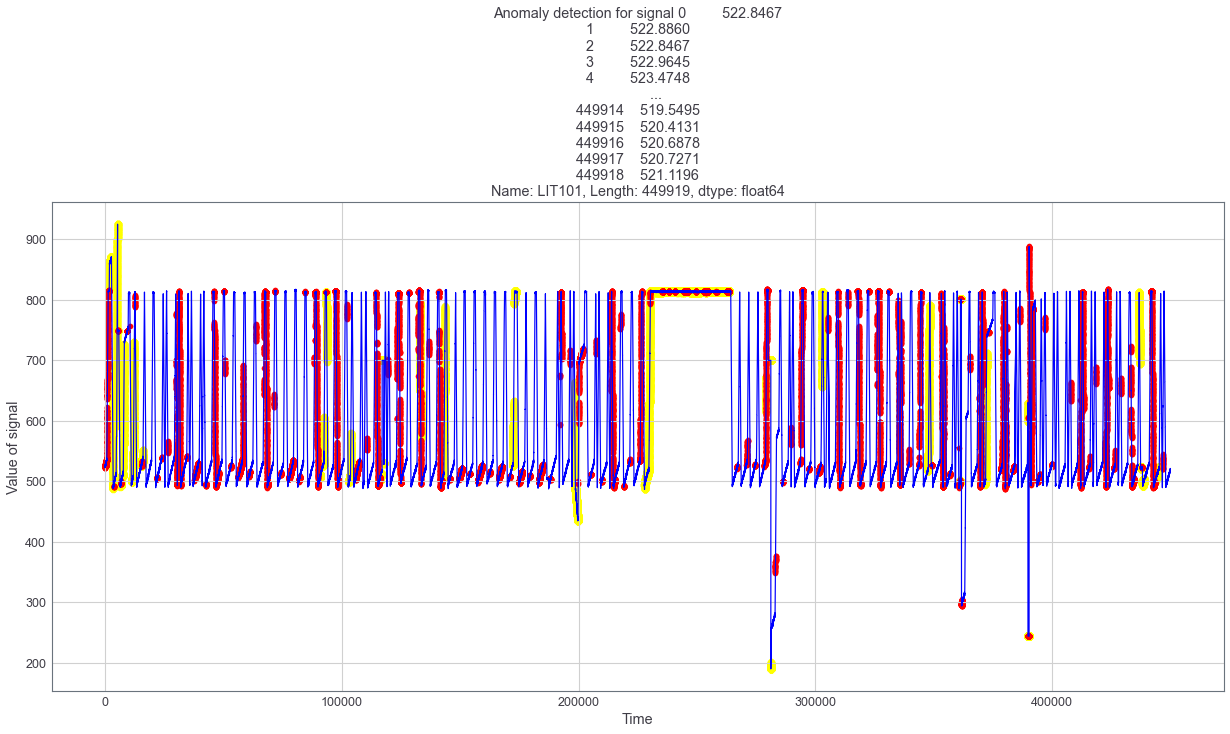

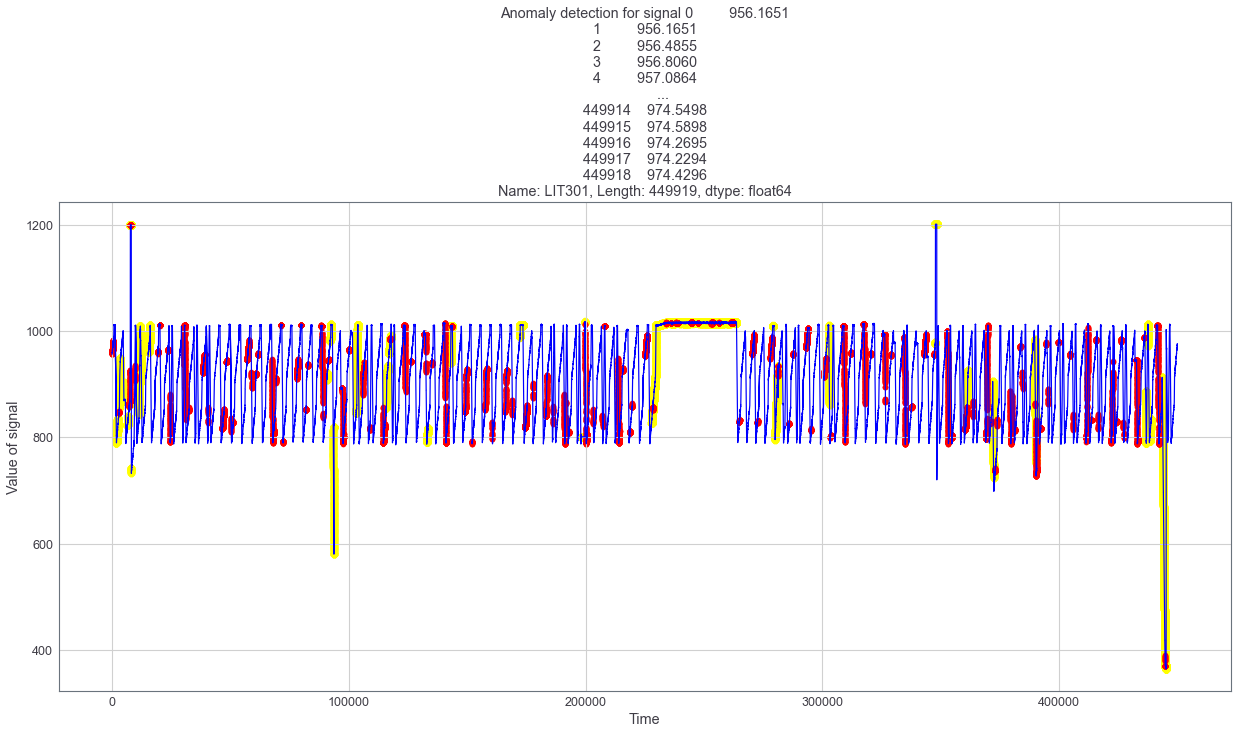

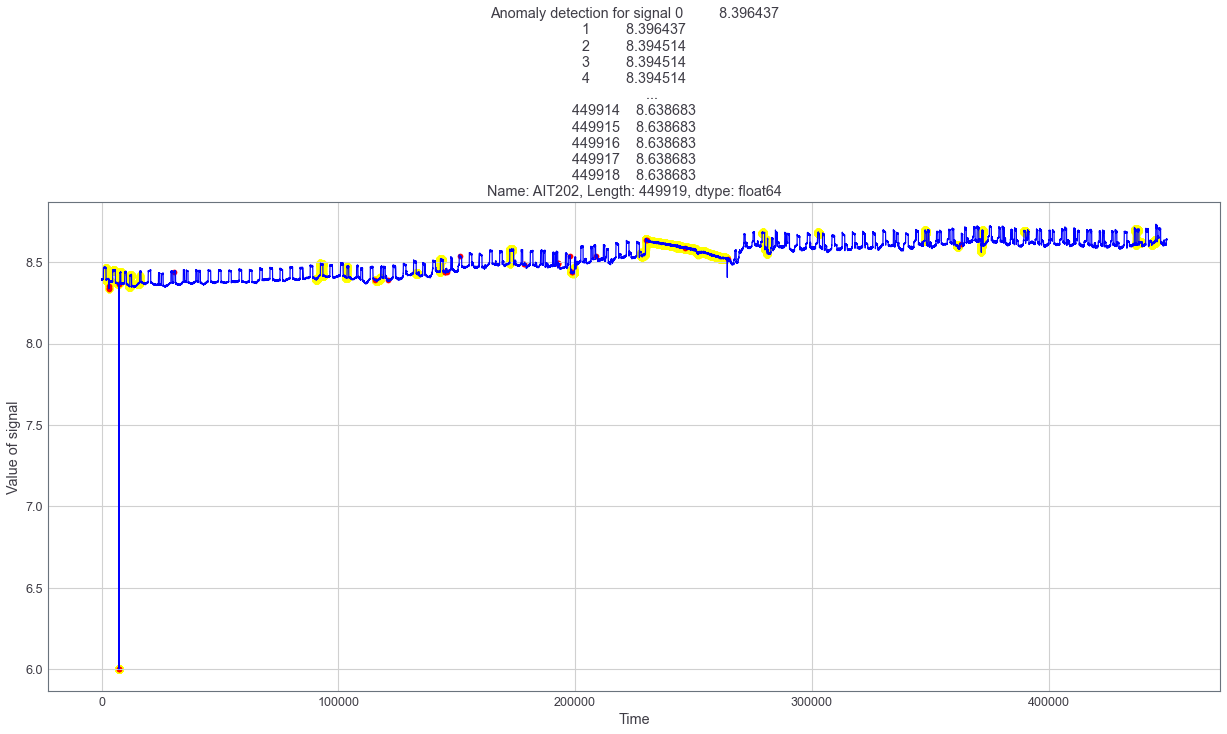

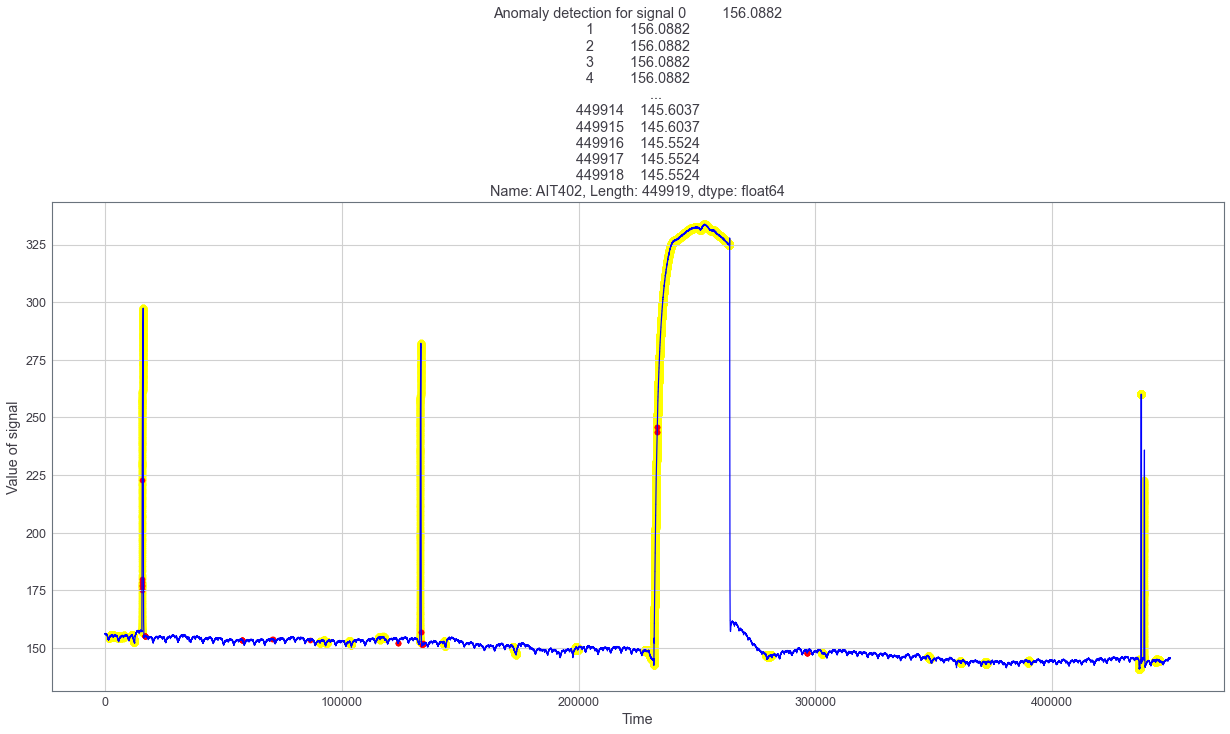

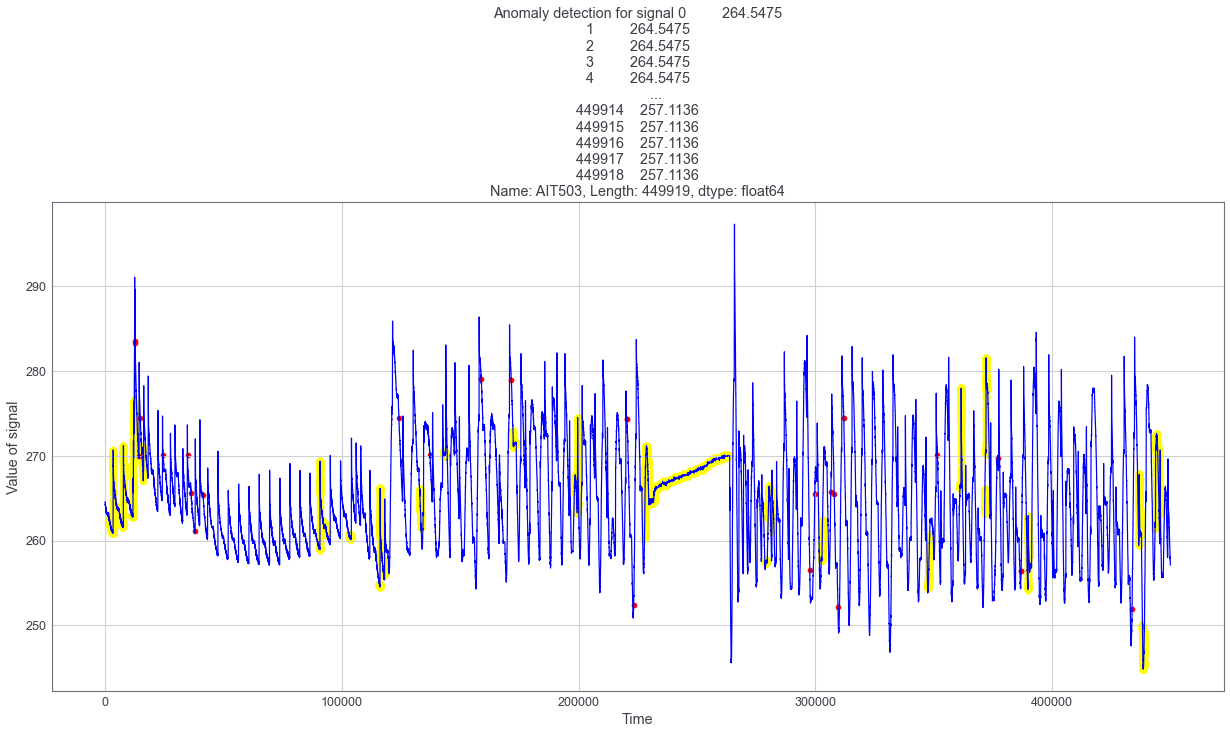

In [132]:
show_ngram_result(ngram_signals)

### 5b. Analysis and answers to the questions. Also provide relevant plots.

#### Plot the anomalies you find. What kind of anomalies can / can you not detect?
For signal `LIT101`, the N-gram model finds the contextual anomaly from around point 240000 to around point 270000. And it also finds three-point anomalies around the points 360000 and 380000 in the test data set. However, it mistakenly marks many normal points as anomalies.

For signal `LIT301`, the N-gram model finds the contextual anomaly around the point 250000 and two-point anomaly around the point 10000 and 460000 in the test data set. It fails to find another two obvious point anomaly - around the point 95000 and 350000 in the test data set.

For signal `AIT202`, the N-gram model marks several points in the contextual anomaly around 230000 to 260000 which reflects that it successfully judges them as collective anomalies.

For signal `AIT402`, the N-gram model distinguishes several points in the contextual anomalies around point 235000, however, the number of its marking is quite smaller than the real number of outliers.

For signal `AIT503`, the N-gram model marks some point anomalies while it fails to detect the obvious contextual anomaly from point 230000 to point 270000.

#### Which sensors can be modeled effectively using N-grams?
As the classification we make in table, we implement the N-grams model on three kinds of signals. For the first type of signal- periodic change within a certain range, signal `LIT101` and `LIT301`, this model marks more points as an anomaly which increases the false positive value. For the second type - continuous drift, the signal `AIT202`, `AIT402` and `AIT503`, the N-gram model marks fewer points as anomalies, which results in a lower true positive value.

The N-grams model is more suitable for detecting anomalies in the signal which changes periodically within a certain range.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

![Confusion Matrix of LOF](./figures/LOF_confusion.png)
<center> Confusion Matrix of LOF </center>

![Confusion Matrix of PCA](./figures/PCA_confusion.png)
<center> Confusion Matrix of PCA </center>

![Partially Predicted Result of ARIMA](./figures/arima_res.png)
<center> Partially Predicted Result of ARIMA </center>

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

In [ ]:
#